In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold, KFold, cross_validate
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    auc,
    brier_score_loss,
    confusion_matrix,
    precision_score,
    recall_score
)
from sklearn.preprocessing import StandardScaler

### Data cleaning & preprocessing

In [ ]:
file_path = '/content/drive/MyDrive/cardio_train.csv'
cardio = pd.read_csv(file_path)
cardio.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [ ]:
cardio['cardio'].value_counts()

cardio
0    35021
1    34979
Name: count, dtype: int64

In [ ]:
df = cardio.copy()
df.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [ ]:
df = df.drop(columns=['id'])
df.head()

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  18393       2     168    62.0    110     80            1     1      0   
1  20228       1     156    85.0    140     90            3     1      0   
2  18857       1     165    64.0    130     70            3     1      0   
3  17623       2     169    82.0    150    100            1     1      0   
4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [ ]:
df.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [ ]:
df.duplicated().sum()

np.int64(24)

In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [ ]:
df['age'] = df['age'] // 365

In [ ]:
df.head()

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0   50       2     168    62.0    110     80            1     1      0     0   
1   55       1     156    85.0    140     90            3     1      0     0   
2   51       1     165    64.0    130     70            3     1      0     0   
3   48       2     169    82.0    150    100            1     1      0     0   
4   47       1     156    56.0    100     60            1     1      0     0   

   active  cardio  
0       1       0  
1       1       1  
2       0       1  
3       1       1  
4       0       0

In [ ]:
df['gender'] = df['gender'] - 1

In [ ]:
df = pd.get_dummies(df, columns=['cholesterol', 'gluc'], drop_first=True, dtype=int)

In [ ]:
df = df[(df['height'] >= 130) & (df['height'] <= 210)]
df = df[(df['weight'] >= 30) & (df['weight'] <= 200)]
df = df[(df['ap_hi'] >= 90) & (df['ap_hi'] <= 200)]
df = df[(df['ap_lo'] >= 60) & (df['ap_lo'] <= 130)]

In [ ]:
df['bmi'] = df['weight'] / (df['height'] / 100) ** 2
df = df.drop(columns=['height', 'weight'])

In [ ]:
df = df[(df['bmi'] >= 10) & (df['bmi'] <= 60)]
df.head()

age  gender  ap_hi  ap_lo  smoke  alco  active  cardio  cholesterol_2  \
0   50       1    110     80      0     0       1       0              0   
1   55       0    140     90      0     0       1       1              0   
2   51       0    130     70      0     0       0       1              0   
3   48       1    150    100      0     0       1       1              0   
4   47       0    100     60      0     0       0       0              0   

   cholesterol_3  gluc_2  gluc_3        bmi  
0              0       0       0  21.967120  
1              1       0       0  34.927679  
2              1       0       0  23.507805  
3              0       0       0  28.710479  
4              0       0       0  23.011177

In [ ]:
df.describe()

age        gender         ap_hi         ap_lo         smoke  \
count  68307.000000  68307.000000  68307.000000  68307.000000  68307.000000   
mean      52.832565      0.348866    126.656097     81.343113      0.087912   
std        6.767236      0.476615     16.399579      9.266984      0.283169   
min       29.000000      0.000000     90.000000     60.000000      0.000000   
25%       48.000000      0.000000    120.000000     80.000000      0.000000   
50%       53.000000      0.000000    120.000000     80.000000      0.000000   
75%       58.000000      1.000000    140.000000     90.000000      0.000000   
max       64.000000      1.000000    200.000000    130.000000      1.000000   

               alco        active        cardio  cholesterol_2  cholesterol_3  \
count  68307.000000  68307.000000  68307.000000   68307.000000   68307.000000   
mean       0.053406      0.803461      0.495001       0.135213       0.114747   
std        0.224843      0.397384      0.499979       0.341954       0.318718   
min        0.000000      0.000000      0.000000       0.000000       0.000000   
25%        0.000000      1.000000      0.000000       0.000000       0.000000   
50%        0.000000      1.000000      0.000000       0.000000       0.000000   
75%        0.000000      1.000000      1.000000       0.000000       0.000000   
max        1.000000      1.000000      1.000000       1.000000       1.000000   

             gluc_2        gluc_3           bmi  
count  68307.000000  68307.000000  68307.000000  
mean       0.073667      0.076098     27.436358  
std        0.261231      0.265156      5.164184  
min        0.000000      0.000000     10.726644  
25%        0.000000      0.000000     23.875115  
50%        0.000000      0.000000     26.346494  
75%        0.000000      0.000000     30.116213  
max        1.000000      1.000000     59.523810

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68307 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            68307 non-null  int64  
 1   gender         68307 non-null  int64  
 2   ap_hi          68307 non-null  int64  
 3   ap_lo          68307 non-null  int64  
 4   smoke          68307 non-null  int64  
 5   alco           68307 non-null  int64  
 6   active         68307 non-null  int64  
 7   cardio         68307 non-null  int64  
 8   cholesterol_2  68307 non-null  int64  
 9   cholesterol_3  68307 non-null  int64  
 10  gluc_2         68307 non-null  int64  
 11  gluc_3         68307 non-null  int64  
 12  bmi            68307 non-null  float64
dtypes: float64(1), int64(12)
memory usage: 7.3 MB


In [ ]:
df['cardio'].value_counts()

cardio
0    34495
1    33812
Name: count, dtype: int64

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
# Prepare features for VIF
X = df.drop(columns=['cardio'])  # exclude target variable
X_const = add_constant(X)

# Calculate VIF
vif_df = pd.DataFrame()
vif_df["feature"] = X_const.columns
vif_df["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

vif_df.sort_values(by="VIF", ascending=False)

feature         VIF
0           const  139.567664
3           ap_hi    2.241749
4           ap_lo    2.154855
9   cholesterol_3    1.391361
11         gluc_3    1.315419
5           smoke    1.247315
2          gender    1.160324
6            alco    1.139728
12            bmi    1.129576
8   cholesterol_2    1.124601
10         gluc_2    1.100018
1             age    1.069077
7          active    1.001615

### EDA

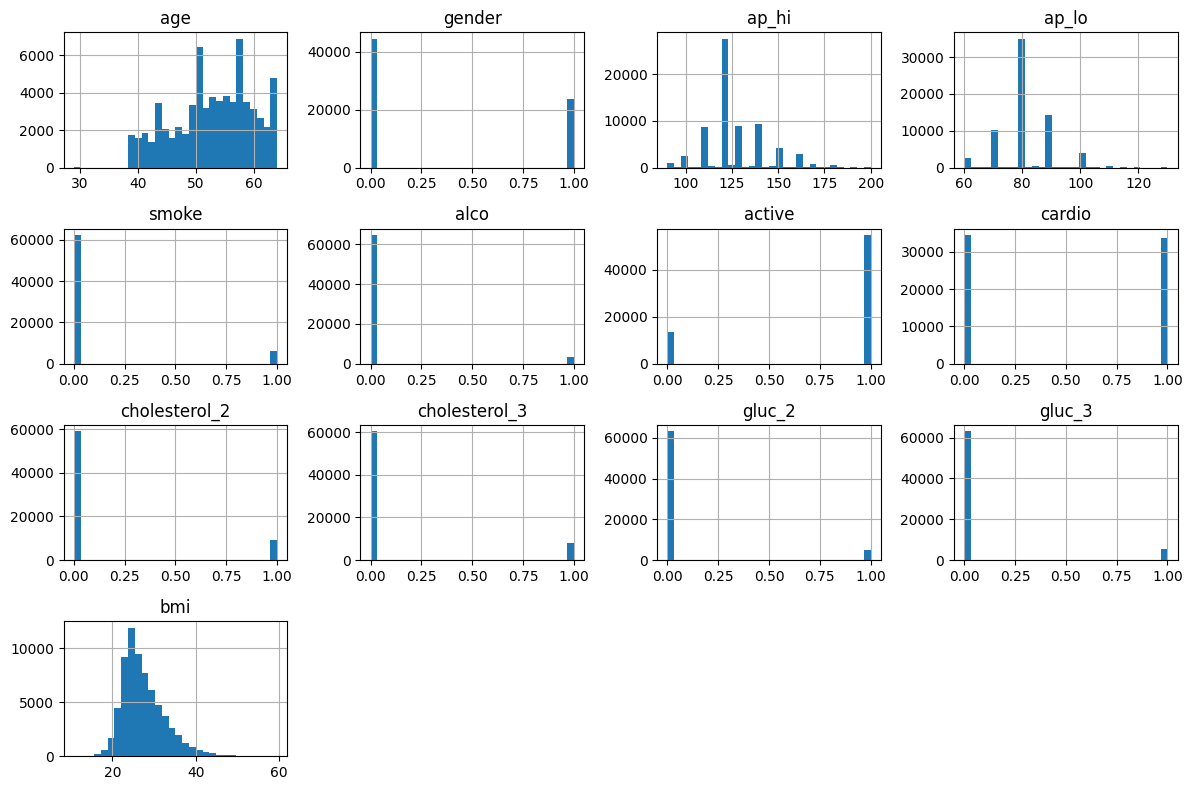

In [ ]:
# Histograms for numerical columns
df.hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

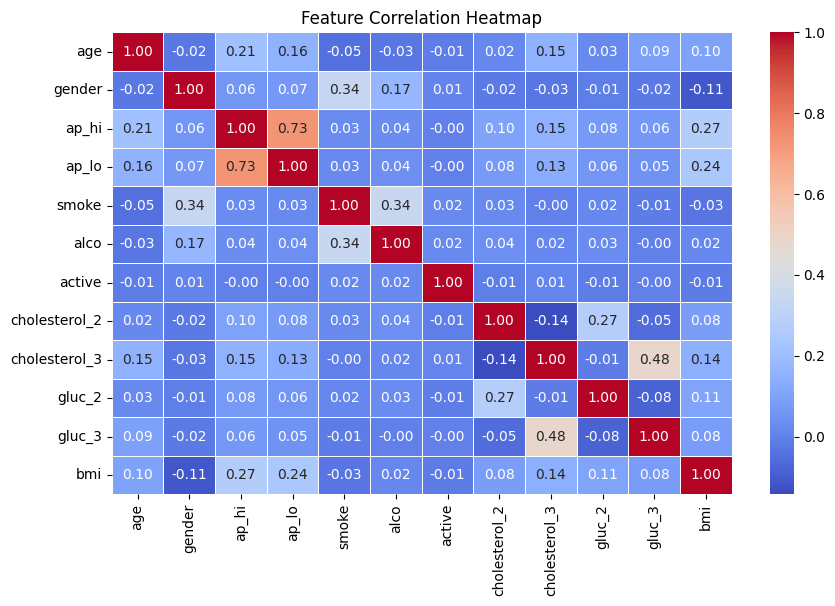

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop('cardio', axis=1).corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

Text(0, 0.5, 'Frequency')

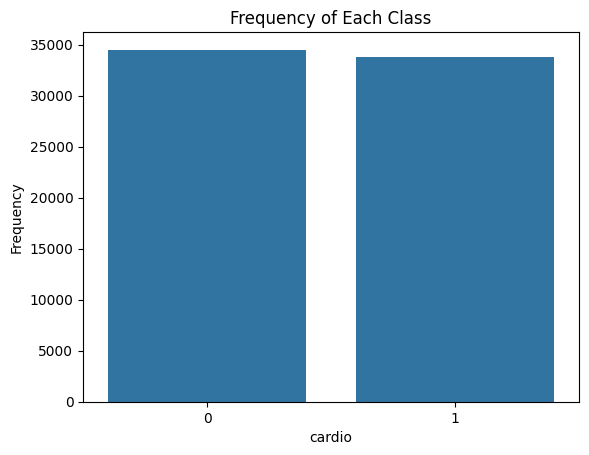

In [ ]:
sns.countplot(x='cardio', data=df)
plt.title('Frequency of Each Class')
plt.ylabel('Frequency')

<Axes: xlabel='bmi', ylabel='Density'>

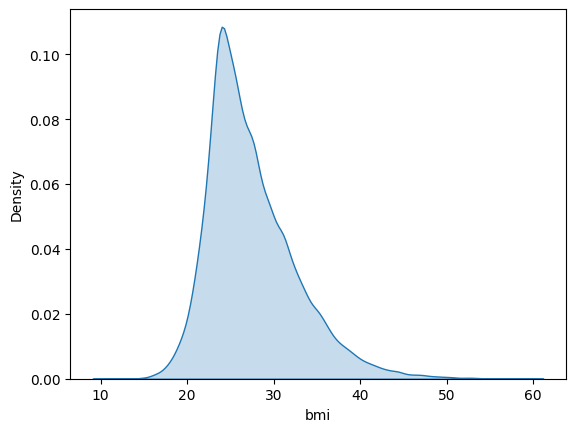

In [ ]:
sns.kdeplot(df['bmi'], fill=True)

<Axes: xlabel='age', ylabel='Density'>

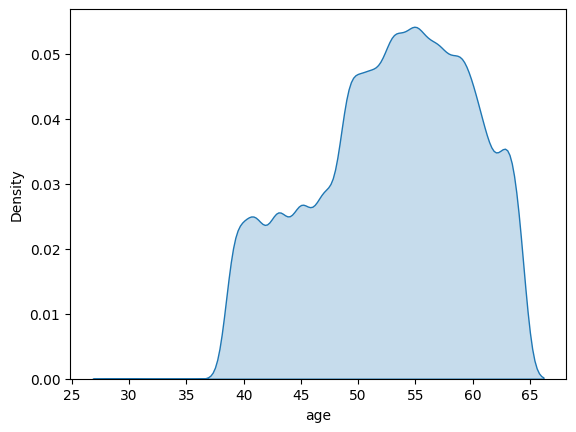

In [ ]:
sns.kdeplot(df['age'], fill=True)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc

#### Setup

In [ ]:
# Set seed
SEED = 42

# Define features and target variable
X = df.drop(columns=['cardio'])
y = df['cardio']

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# Standardize the features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Finding the Optimal Regularization (C)

In [ ]:
C_values = 10. ** np.arange(-4, 5)
best_auc = 0
best_c = None

for c in C_values:
    model = LogisticRegression(penalty="l1", C=c, solver="saga", max_iter=10000)
    model.fit(X_train_scaled, y_train)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]  # probability of class 1
    roc_auc = roc_auc_score(y_test, y_prob)

    if roc_auc > best_auc:
        best_auc = roc_auc
        best_c = c

print(f"Best C: {best_c}")
print(f"Best AUC: {best_auc:.4f}")

Best C: 0.01
Best AUC: 0.7946


#### Training

Define metric calculation function

In [ ]:
def metric_calculation(y_test, y_predict, y_prob):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)

    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    fpr_array, tpr_array, thresholds_array = roc_curve(y_test, y_prob[:, 1])
    closest_index = np.argmin(np.abs(tpr_array - tpr))
    threshold = thresholds_array[closest_index]

    auc_score = auc(fpr_array, tpr_array)
    return accuracy, precision, recall, f1, fpr, auc_score, threshold, fpr_array, tpr_array

Baseline Logistic Regression Model

In [ ]:
log_reg = LogisticRegression(penalty='l1', C=best_c, solver='saga', max_iter=10000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)

print("=== Baseline Logistic Regression ===")
acc, prec, rec, f1, fpr_base, auc_base, _, fpr_arr_base, tpr_arr_base = metric_calculation(y_test, y_pred, y_prob)
brier = brier_score_loss(y_test, y_prob[:, 1])

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"False Positive Rate: {fpr_base:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"AUC: {auc_base:.4f}")

# Cross-Validation (KFold)
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_model = LogisticRegression(penalty='l1', C=best_c, solver='saga', max_iter=10000)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = cross_validate(cv_model, X_train_scaled, y_train, scoring=scoring, cv=kf)

print("\n=== Cross-Validation Results (Baseline, 5-Fold) ===")
for metric in scoring:
    mean = cv_results[f'test_{metric}'].mean()
    std = cv_results[f'test_{metric}'].std()
    print(f"{metric:<10}: Mean = {mean:.4f}, Std = {std:.4f}")


=== Baseline Logistic Regression ===
Confusion Matrix:
 [[5495 1404]
 [2204 4559]]
Accuracy: 0.7359
Precision: 0.7645
Recall: 0.6741
F1 Score: 0.7165
False Positive Rate: 0.2035
Brier Score: 0.1856
AUC: 0.7946

=== Cross-Validation Results (Baseline, 5-Fold) ===
accuracy  : Mean = 0.7265, Std = 0.0049
precision : Mean = 0.7542, Std = 0.0071
recall    : Mean = 0.6638, Std = 0.0044
f1        : Mean = 0.7061, Std = 0.0053
roc_auc   : Mean = 0.7906, Std = 0.0048


Feature Importance

In [ ]:
coef = log_reg.coef_[0]  # Coefficients for class 1
features = X_train.columns  # Feature names

coef_df = pd.DataFrame({"Feature": features, "Coefficient": coef})

# Sort by absolute value to see most influential features
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs_Coefficient", ascending=False)

print(coef_df[["Feature", "Coefficient"]])

          Feature  Coefficient
2           ap_hi     0.906690
0             age     0.333324
8   cholesterol_3     0.323914
11            bmi     0.134900
3           ap_lo     0.117176
7   cholesterol_2     0.115425
6          active    -0.089209
10         gluc_3    -0.068155
5            alco    -0.037187
4           smoke    -0.024539
9          gluc_2     0.004725
1          gender     0.000000


Weighted Models & ROC Plot


=== Logistic Regression with Class Weights: {0: 1, 1: 2} ===
Confusion Matrix:
 [[3327 3572]
 [ 839 5924]]
Accuracy: 0.6771
Precision: 0.6238
Recall: 0.8759
F1 Score: 0.7287
False Positive Rate: 0.5178
Brier Score: 0.2041
AUC: 0.7944
Cross-Validation (5-Fold):
accuracy  : Mean = 0.6750, Std = 0.0038
precision : Mean = 0.6222, Std = 0.0049
recall    : Mean = 0.8746, Std = 0.0032
f1        : Mean = 0.7271, Std = 0.0041
roc_auc   : Mean = 0.7905, Std = 0.0049

Top Feature Importances:
          Feature  Coefficient
2           ap_hi     0.914920
0             age     0.357024
8   cholesterol_3     0.337438
11            bmi     0.148802
7   cholesterol_2     0.123141
3           ap_lo     0.110403
6          active    -0.095149
10         gluc_3    -0.064258
5            alco    -0.042089
4           smoke    -0.031091
9          gluc_2     0.016285
1          gender     0.005093

=== Logistic Regression with Class Weights: {0: 2, 1: 3} ===
Confusion Matrix:
 [[4380 2519]
 [1367 5396]]
A

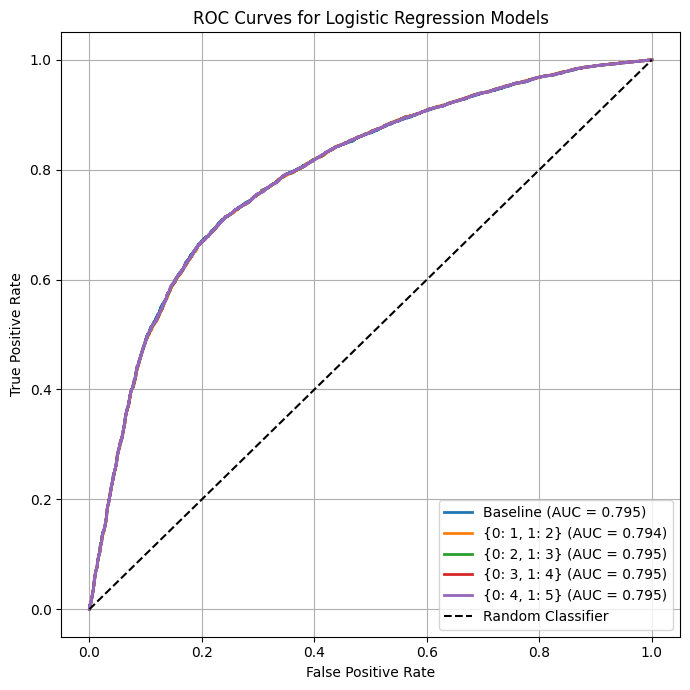

In [ ]:
# ROC curve plot setup
plt.figure(figsize=(7, 7))
plt.plot(fpr_arr_base, tpr_arr_base, label=f"Baseline (AUC = {auc_base:.3f})", linewidth=2)

# Weighted models
weight_configs = [{0:1, 1:2}, {0:2, 1:3}, {0:3, 1:4}, {0:4, 1:5}]
for weights in weight_configs:
    model = LogisticRegression(penalty='l1', C=best_c, solver='saga', max_iter=10000, class_weight=weights)
    model.fit(X_train_scaled, y_train)
    y_pred_w = model.predict(X_test_scaled)
    y_prob_w = model.predict_proba(X_test_scaled)

    print(f"\n=== Logistic Regression with Class Weights: {weights} ===")
    acc, prec, rec, f1, fpr_w, auc_w, _, fpr_arr, tpr_arr = metric_calculation(y_test, y_pred_w, y_prob_w)
    brier_w = brier_score_loss(y_test, y_prob_w[:, 1])

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_w))
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"False Positive Rate: {fpr_w:.4f}")
    print(f"Brier Score: {brier_w:.4f}")
    print(f"AUC: {auc_w:.4f}")

    # Cross-Validation
    cv_model_w = LogisticRegression(penalty='l1', C=best_c, solver='saga', max_iter=10000, class_weight=weights)
    cv_results_w = cross_validate(cv_model_w, X_train_scaled, y_train, scoring=scoring, cv=kf)

    print("Cross-Validation (5-Fold):")
    for metric in scoring:
        mean = cv_results_w[f'test_{metric}'].mean()
        std = cv_results_w[f'test_{metric}'].std()
        print(f"{metric:<10}: Mean = {mean:.4f}, Std = {std:.4f}")

    # Feature Importance
    coef_w = model.coef_[0]
    coef_df_w = pd.DataFrame({
        "Feature": X_train.columns,
        "Coefficient": coef_w,
        "Abs_Coefficient": np.abs(coef_w)
    })
    coef_df_w = coef_df_w.sort_values(by="Abs_Coefficient", ascending=False)
    print("\nTop Feature Importances:")
    print(coef_df_w[["Feature", "Coefficient"]])

    # ROC Curve
    plt.plot(fpr_arr, tpr_arr, label=f"{weights} (AUC = {auc_w:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label="Random Classifier")
plt.title("ROC Curves for Logistic Regression Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Random forest model

In [ ]:
# random forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_validate, KFold, RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss, ConfusionMatrixDisplay, f1_score, auc
from sklearn.calibration import calibration_curve

x_rf = df.drop('cardio', axis=1)
y_rf = df['cardio']

x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(x_rf, y_rf, test_size=0.2, random_state=56, stratify=y_rf)

# create dummy model to choose the best parameter to train the model
init_rf = RandomForestClassifier(random_state=42)

# list of parameters for randomizedsearchcv function to find the best parameter
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

# Run RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=init_rf,
    param_distributions=parameters,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search.fit(x_train_rf, y_train_rf)
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy'}


======== Baseline Random Forest Model ========
Accuracy: 0.7345191040843215
Precision: 0.758864056461099
Recall: 0.6732259988073942
F1-score: 0.7134844774468757
Confusion Matrix:



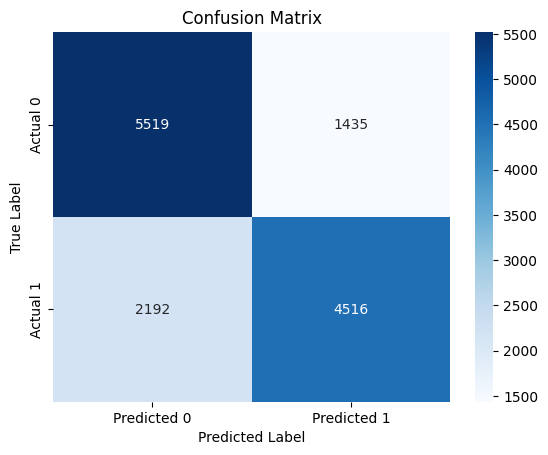

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.79      0.75      6954
           1       0.76      0.67      0.71      6708

    accuracy                           0.73     13662
   macro avg       0.74      0.73      0.73     13662
weighted avg       0.74      0.73      0.73     13662


Brier Score: 0.1807
False Positive Rate: 0.20635605406960023
AUC: 0.800176106157355


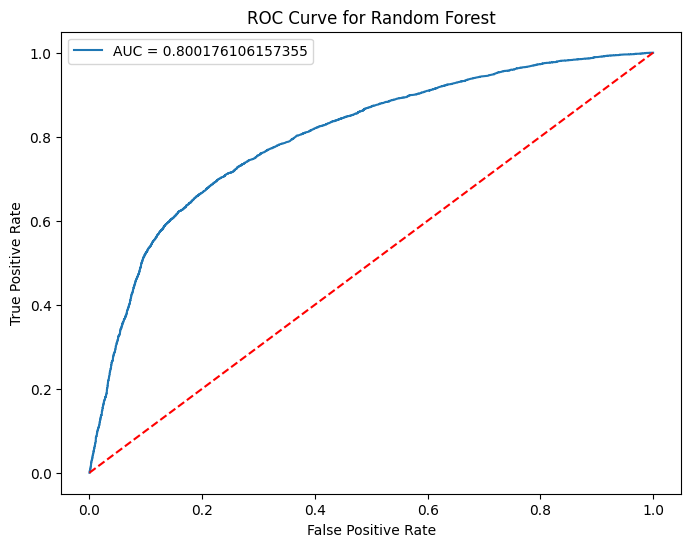

======== Cross-Validation (5-Fold): ========
accuracy  : Mean = 0.7340, Std = 0.0038
precision : Mean = 0.7582, Std = 0.0051
recall    : Mean = 0.6810, Std = 0.0086
f1        : Mean = 0.7175, Std = 0.0048
roc_auc   : Mean = 0.8000, Std = 0.0034


In [ ]:
# implement best parameters into the model
rf = RandomForestClassifier(
    n_estimators=50,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    max_depth=10,
    criterion='entropy',
    random_state=42
)

#cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
scores = cross_validate(rf, x_train_rf, y_train_rf, cv=kf, scoring=scoring)
# Fit the model on the entire training set
rf.fit(x_train_rf, y_train_rf)

# Predictions on the test set
y_pred = rf.predict(x_test_rf)
y_probs = rf.predict_proba(x_test_rf)[:, 1]  # Probabilities for class 1

# Evaluate the performance of the RandomForest model
print("======== Baseline Random Forest Model ========")
print("Accuracy:", accuracy_score(y_test_rf, y_pred))
print("Precision:", precision_score(y_test_rf, y_pred))
print("Recall:", recall_score(y_test_rf, y_pred))
print("F1-score:", f1_score(y_test_rf, y_pred))
print("Confusion Matrix:\n")
cm = confusion_matrix(y_test_rf, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print("Classification Report:\n", classification_report(y_test_rf, y_pred))

brier_score = brier_score_loss(y_test_rf, y_probs)
print(f"\nBrier Score: {brier_score:.4f}")
tn, fp, fn, tp = cm.ravel()  # Get values from the confusion matrix
fpr = fp / (fp + tn)
print("False Positive Rate:", fpr)
fpr_array, tpr_array, thresholds_array = roc_curve(y_test_rf, y_probs)
auc_score = auc(fpr_array, tpr_array)
print("AUC:", auc_score)
#AUC ROC curve
auc_roc = roc_auc_score(y_test_rf, y_probs)
fpr, tpr, _ = roc_curve(y_test_rf, y_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_roc}")
plt.plot([0,1], [0,1], 'r--')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random Forest")
plt.legend()
plt.show()

print("======== Cross-Validation (5-Fold): ========")
for metric in scoring:
    mean = scores[f'test_{metric}'].mean()
    std = scores[f'test_{metric}'].std()
    print(f"{metric:<10}: Mean = {mean:.4f}, Std = {std:.4f}")

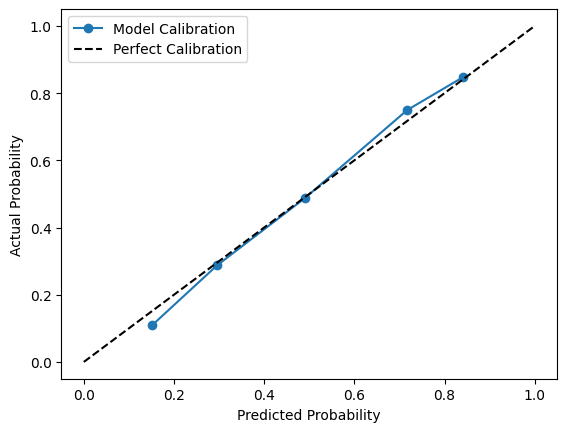

In [ ]:
# performed caliberation matrix (source: https://medium.com/codex/metrics-to-measuring-calibration-in-deep-learning-36b0b11fe816)

true_prob, pred_prob = calibration_curve(y_test_rf, y_probs, n_bins=5)

plt.plot(pred_prob, true_prob, marker='o', label="Model Calibration")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Probability")
plt.legend()
plt.show()


======== Random Forest Model With Weights 1 for Class 0, Weights 2 for Class 1 ========
Accuracy: 0.696164543990631
Precision: 0.6467684536792561
Recall: 0.8398926654740608
F1-score 0.7307866917439523
FNR: 0.16010733452593917
FPR: 0.44247914869140065
AUC: 0.7999723543195261

Brier Score: 0.1985
Confusion Matrix:



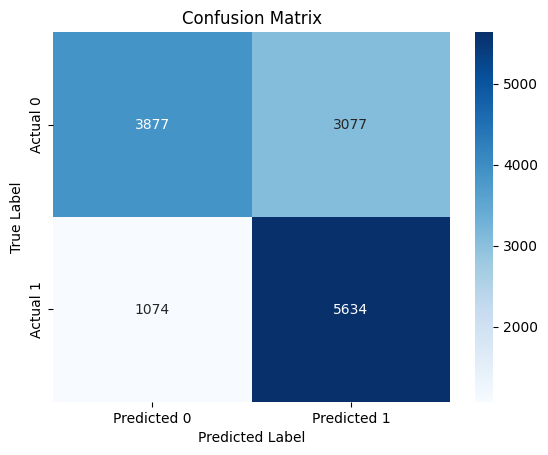

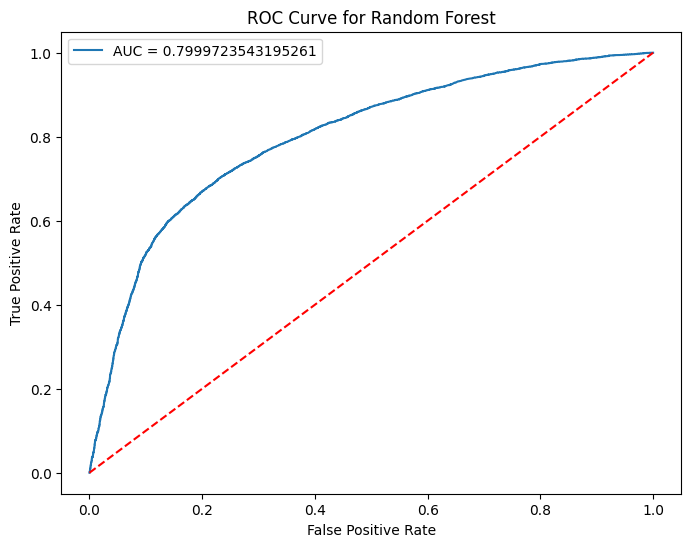

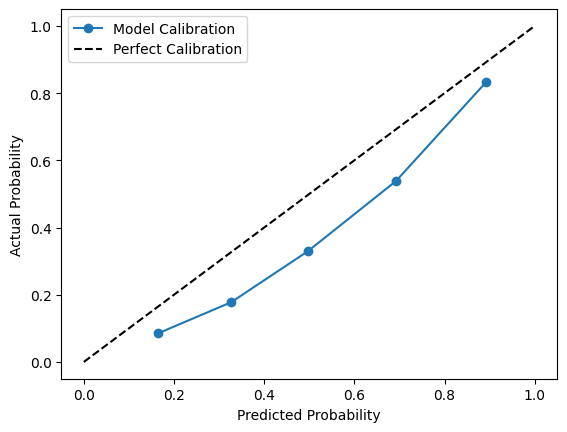

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.56      0.65      6954
           1       0.65      0.84      0.73      6708

    accuracy                           0.70     13662
   macro avg       0.71      0.70      0.69     13662
weighted avg       0.72      0.70      0.69     13662


======== Cross-Validation (5-Fold): ========
accuracy  : Mean = 0.7340, Std = 0.0038
precision : Mean = 0.7582, Std = 0.0051
recall    : Mean = 0.6810, Std = 0.0086
f1        : Mean = 0.7175, Std = 0.0048
roc_auc   : Mean = 0.8000, Std = 0.0034

======== Random Forest Model With Weights 2 for Class 0, Weights 3 for Class 1 ========
Accuracy: 0.7241985068072024
Precision: 0.7005457025920873
Recall: 0.7655038759689923
F1-score 0.7315856959680866
FNR: 0.23449612403100775
FPR: 0.31564567155593903
AUC: 0.799278854192874

Brier Score: 0.1871
Confusion Matrix:



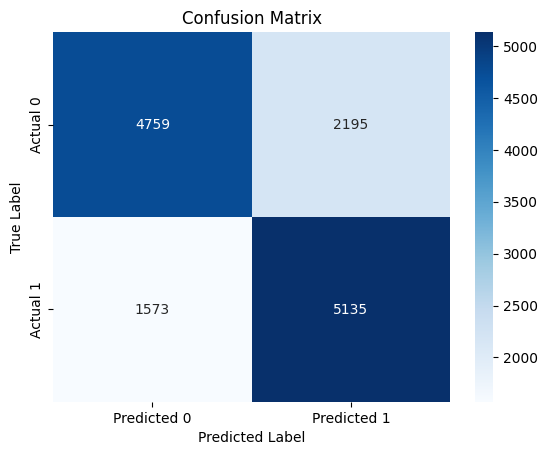

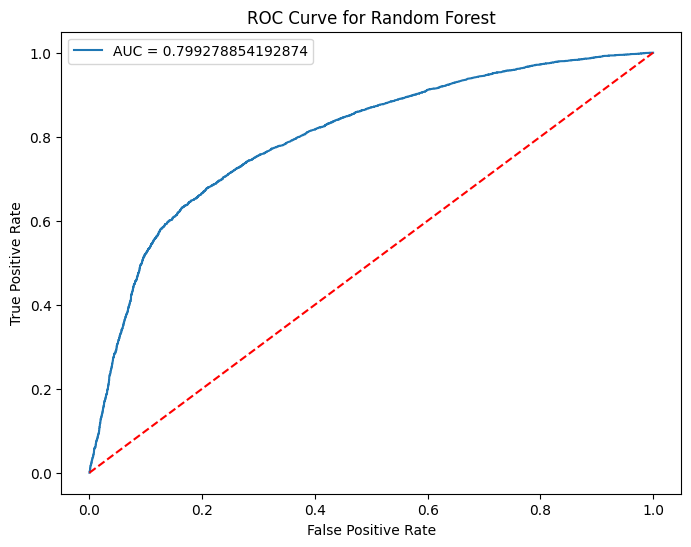

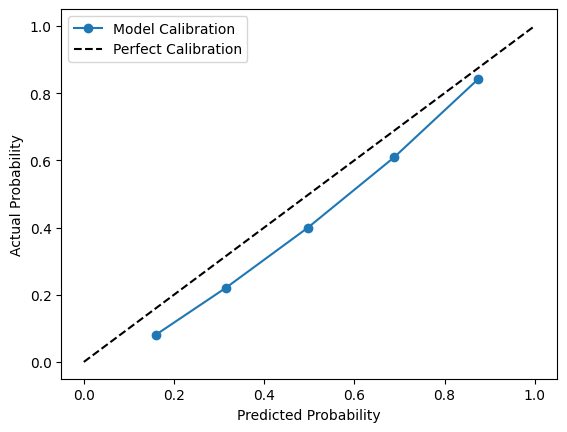

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.68      0.72      6954
           1       0.70      0.77      0.73      6708

    accuracy                           0.72     13662
   macro avg       0.73      0.72      0.72     13662
weighted avg       0.73      0.72      0.72     13662


======== Cross-Validation (5-Fold): ========
accuracy  : Mean = 0.7340, Std = 0.0038
precision : Mean = 0.7582, Std = 0.0051
recall    : Mean = 0.6810, Std = 0.0086
f1        : Mean = 0.7175, Std = 0.0048
roc_auc   : Mean = 0.8000, Std = 0.0034

======== Random Forest Model With Weights 3 for Class 0, Weights 4 for Class 1 ========
Accuracy: 0.729541794759186
Precision: 0.7175451263537906
Recall: 0.740757304710793
F1-score 0.7289664783980049
FNR: 0.2592426952892069
FPR: 0.2812769628990509
AUC: 0.799384122581496

Brier Score: 0.1840
Confusion Matrix:



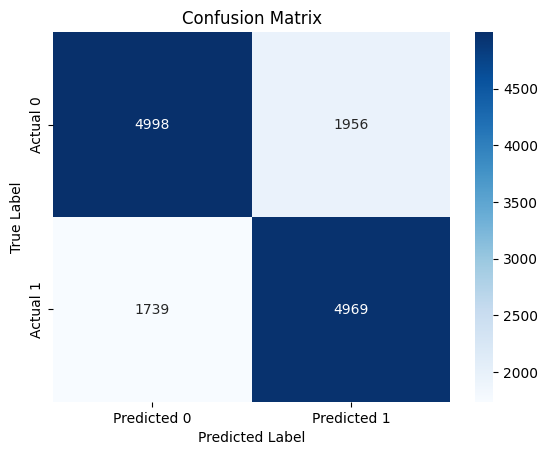

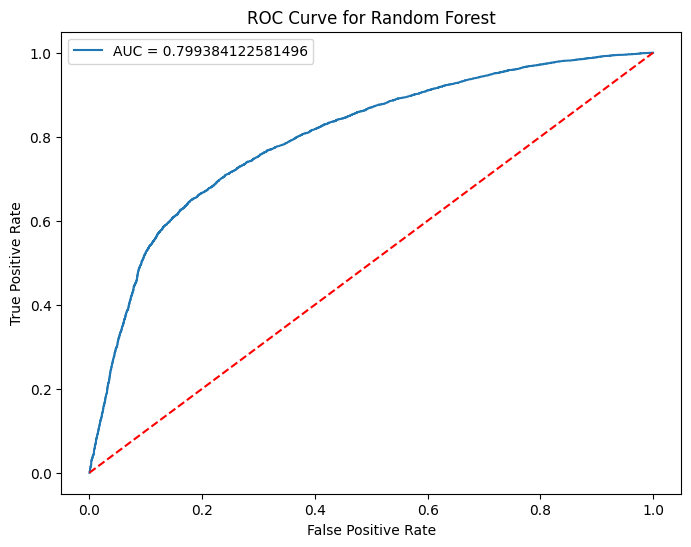

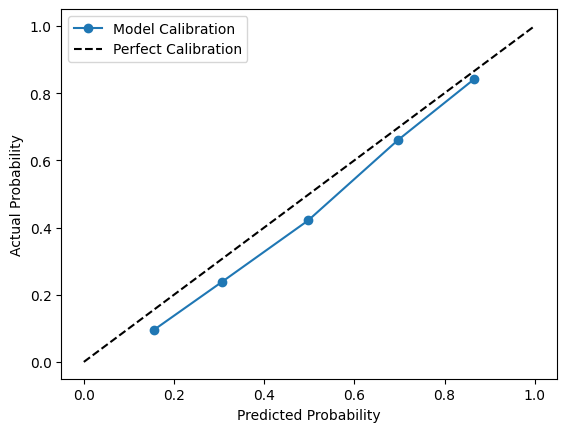

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.72      0.73      6954
           1       0.72      0.74      0.73      6708

    accuracy                           0.73     13662
   macro avg       0.73      0.73      0.73     13662
weighted avg       0.73      0.73      0.73     13662


======== Cross-Validation (5-Fold): ========
accuracy  : Mean = 0.7340, Std = 0.0038
precision : Mean = 0.7582, Std = 0.0051
recall    : Mean = 0.6810, Std = 0.0086
f1        : Mean = 0.7175, Std = 0.0048
roc_auc   : Mean = 0.8000, Std = 0.0034

======== Random Forest Model With Weights 4 for Class 0, Weights 5 for Class 1 ========
Accuracy: 0.730346947738252
Precision: 0.7248661511005354
Recall: 0.7265951103160405
F1-score 0.7257296009529481
FNR: 0.27340488968395943
FPR: 0.2660339373022721
AUC: 0.7994142099826631

Brier Score: 0.1828
Confusion Matrix:



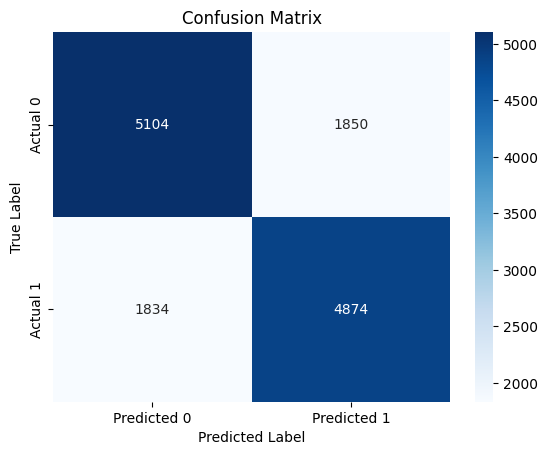

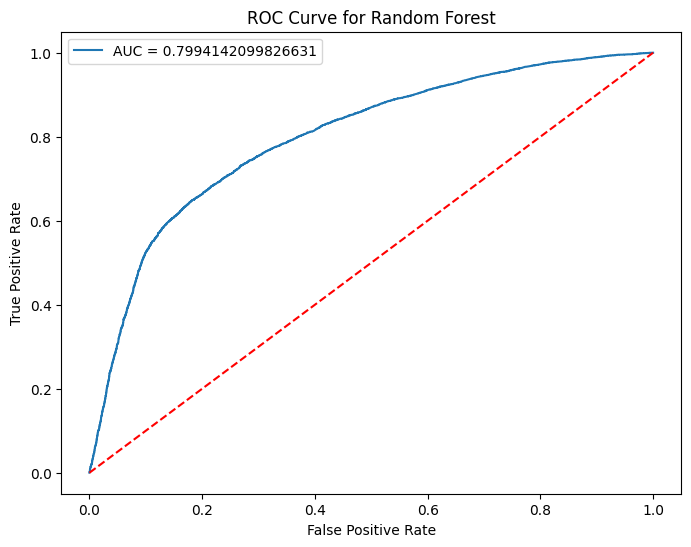

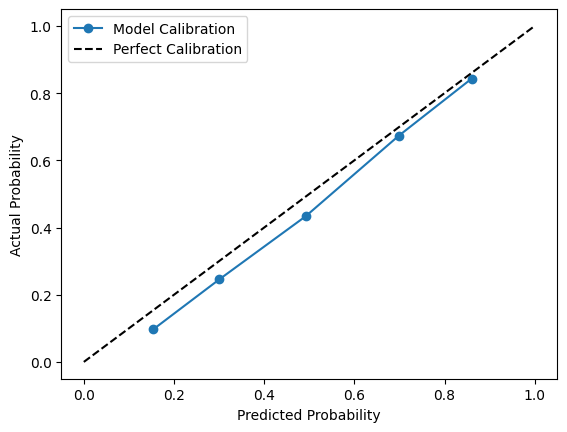

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.73      6954
           1       0.72      0.73      0.73      6708

    accuracy                           0.73     13662
   macro avg       0.73      0.73      0.73     13662
weighted avg       0.73      0.73      0.73     13662


======== Cross-Validation (5-Fold): ========
accuracy  : Mean = 0.7340, Std = 0.0038
precision : Mean = 0.7582, Std = 0.0051
recall    : Mean = 0.6810, Std = 0.0086
f1        : Mean = 0.7175, Std = 0.0048
roc_auc   : Mean = 0.8000, Std = 0.0034


In [ ]:

weight_ratios = [(1,2), (2,3), (3,4), (4,5)]
weight_labels = ["Weight 1:2", "Weight 2:3", "Weight 3:4", "Weight 4:5"]


def get_sample_weights(y, weights_ratio):
    return np.where(y == 0, weights_ratio[0], weights_ratio[1])


for ratio, label in zip(weight_ratios, weight_labels):
    # Compute sample weights
    sample_weights = get_sample_weights(y_train_rf, ratio)
    rf_weights = RandomForestClassifier(
        n_estimators=50,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        max_depth=10,
        criterion='entropy',
        random_state=42
      )
    #cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    scores = cross_validate(rf_weights, x_train_rf, y_train_rf, cv=kf, scoring=scoring)

    rf_weights.fit(x_train_rf, y_train_rf, sample_weight=sample_weights)
    y_pred = rf_weights.predict(x_test_rf)
    y_probs = rf_weights.predict_proba(x_test_rf)[:, 1]

    # print evaluation metrics
    print(f"\n======== Random Forest Model With Weights {ratio[0]} for Class 0, Weights {ratio[1]} for Class 1 ========")
    print(f"Accuracy:", accuracy_score(y_test_rf, y_pred))
    print("Precision:", precision_score(y_test_rf, y_pred))
    print("Recall:", recall_score(y_test_rf, y_pred))
    print("F1-score", f1_score(y_test_rf, y_pred))
    cm = confusion_matrix(y_test_rf, y_pred)
    tn, fp, fn, tp = cm.ravel()  # get values from the confusion matrix
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    print("FNR:", fnr)
    print("FPR:", fpr)
    fpr_array, tpr_array, thresholds_array = roc_curve(y_test_rf, y_probs)
    auc_score = auc(fpr_array, tpr_array)
    print("AUC:", auc_score)
    brier_score = brier_score_loss(y_test_rf, y_probs)
    print(f"\nBrier Score: {brier_score:.4f}")

    #plot confusion matrix
    print(f"Confusion Matrix:\n")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    #plot roc curve
    auc_roc = roc_auc_score(y_test_rf, y_probs)
    fpr, tpr, _ = roc_curve(y_test_rf, y_probs)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_roc}")
    plt.plot([0,1], [0,1], 'r--')  # Random guess line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Random Forest")
    plt.legend()
    plt.show()

    #caliberation matrix
    true_prob, pred_prob = calibration_curve(y_test_rf, y_probs, n_bins=5)

    plt.plot(pred_prob, true_prob, marker='o', label="Model Calibration")
    plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Actual Probability")
    plt.legend()
    plt.show()
    print("Classification Report:\n", classification_report(y_test_rf, y_pred))

    print("\n======== Cross-Validation (5-Fold): ========")
    for metric in scoring:
        mean = scores[f'test_{metric}'].mean()
        std = scores[f'test_{metric}'].std()
        print(f"{metric:<10}: Mean = {mean:.4f}, Std = {std:.4f}")


In [ ]:
# feature importance
importances = rf.feature_importances_
feature_names = x_rf.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print("Feature importance:")
print(feature_importance_df.sort_values(by='Importance', ascending=False))

Feature importance:
          Feature  Importance
2           ap_hi    0.509736
3           ap_lo    0.159439
0             age    0.130427
11            bmi    0.075170
8   cholesterol_3    0.074005
7   cholesterol_2    0.011612
10         gluc_3    0.009412
6          active    0.009197
1          gender    0.005807
4           smoke    0.005511
9          gluc_2    0.005050
5            alco    0.004633


### XGboost model

Finding the best weights

In [ ]:
# Define features and target variable
X = df.drop(columns=['cardio'])
y = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define different weight ratios
weights = [(1,2), (2,3), (3,4), (4,5)]

# Initialize base model configuration
base_model_params = {
    'learning_rate': 0.05,
    'n_estimators': 300,
    'max_depth': 4,
    'min_child_weight': 2,
    'gamma': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'enable_categorical': True
}

# Store performance for different weight ratios
weight_performance = {}

# First, train and evaluate base model without weight adjustment
base_model = xgb.XGBClassifier(**base_model_params)
base_model.fit(X_train, y_train)
base_predictions = base_model.predict(X_test)

# Store base model performance
weight_performance['Base Model'] = {
    'accuracy': accuracy_score(y_test, base_predictions),
    'precision': precision_score(y_test, base_predictions),
    'recall': recall_score(y_test, base_predictions),
    'f1_score': f1_score(y_test, base_predictions)
}

# Train and evaluate model with different weights
for positive_class_weight, negative_class_weight in weights:
    # Copy base model parameters and add current weight
    model_params = base_model_params.copy()
    model_params['scale_pos_weight'] = negative_class_weight / positive_class_weight

    # Create model
    model = xgb.XGBClassifier(**model_params)

    # Train model
    model.fit(X_train, y_train)

    # Predict
    y_predictions = model.predict(X_test)

    # Calculate performance metrics
    weight_performance[f"{positive_class_weight}:{negative_class_weight}"] = {
        'accuracy': accuracy_score(y_test, y_predictions),
        'precision': precision_score(y_test, y_predictions),
        'recall': recall_score(y_test, y_predictions),
        'f1_score': f1_score(y_test, y_predictions)
    }

Model Performance with Different Weights:
            accuracy  precision    recall  f1_score
Base Model  0.740814   0.761356  0.693923  0.726077
1:2         0.706339   0.656538  0.853024  0.741994
2:3         0.729322   0.704633  0.780275  0.740528
3:4         0.735031   0.722309  0.754990  0.738288
4:5         0.737740   0.731981  0.741831  0.736873


<Figure size 1200x600 with 0 Axes>

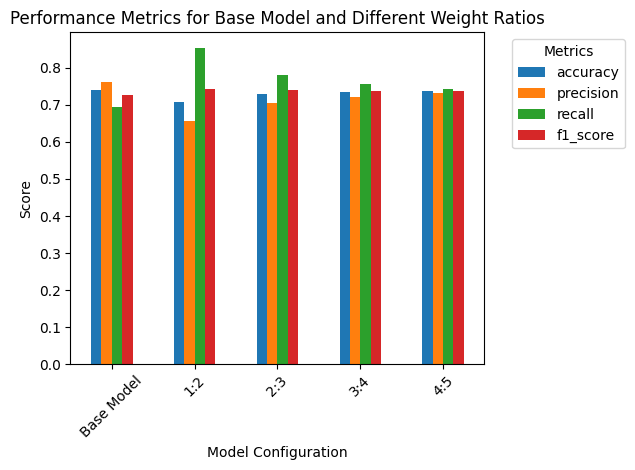


Changes from Base Model:

Weight Ratio 1:2:
  Accuracy Change: -0.0345
  Precision Change: -0.1048
  Recall Change: 0.1591
  F1 Score Change: 0.0159

Weight Ratio 2:3:
  Accuracy Change: -0.0115
  Precision Change: -0.0567
  Recall Change: 0.0864
  F1 Score Change: 0.0145

Weight Ratio 3:4:
  Accuracy Change: -0.0058
  Precision Change: -0.0390
  Recall Change: 0.0611
  F1 Score Change: 0.0122

Weight Ratio 4:5:
  Accuracy Change: -0.0031
  Precision Change: -0.0294
  Recall Change: 0.0479
  F1 Score Change: 0.0108


In [ ]:
# Create performance comparison table
performance_dataframe = pd.DataFrame(weight_performance).T
print("Model Performance with Different Weights:")
print(performance_dataframe)

# Optional: Visualize performance comparison
plt.figure(figsize=(12, 6))
performance_dataframe.plot(kind='bar', rot=45)
plt.title('Performance Metrics for Base Model and Different Weight Ratios')
plt.xlabel('Model Configuration')
plt.ylabel('Score')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Optional: Detailed comparison of changes from base model
print("\nChanges from Base Model:")
for model_name, metrics in weight_performance.items():
    if model_name != 'Base Model':
        print(f"\nWeight Ratio {model_name}:")
        for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
            change = metrics[metric] - weight_performance['Base Model'][metric]
            print(f"  {metric.replace('_', ' ').title()} Change: {change:.4f}")

In [ ]:
# Enhanced XGBoost Model
# Data Preparation
X = df.drop(['cardio'], axis=1)
y = df['cardio']


In [ ]:
# 1. Cross Validation
# Using StratifiedKFold to maintain class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# 2. Compute class weights to improve recall

# Define XGBoost Model with class weights
xgb_model = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=3 / 2
)

# Create Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define Multiple Evaluation Metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# Perform Cross-Validation
cv_results = cross_validate(
    xgb_model,
    X,
    y,
    cv=cv,
    scoring=scoring
)

# Print Cross-Validation Results
print("Cross-Validation Results:")
for metric, scores in cv_results.items():
    if metric.startswith('test_'):
        print(f"{metric[5:].capitalize()} - Mean: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Model Training
xgb_model.fit(X_train, y_train)

Cross-Validation Results:
Accuracy - Mean: 0.7259 (+/- 0.0095)
Precision - Mean: 0.7015 (+/- 0.0095)
Recall - Mean: 0.7769 (+/- 0.0121)
F1 - Mean: 0.7373 (+/- 0.0091)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

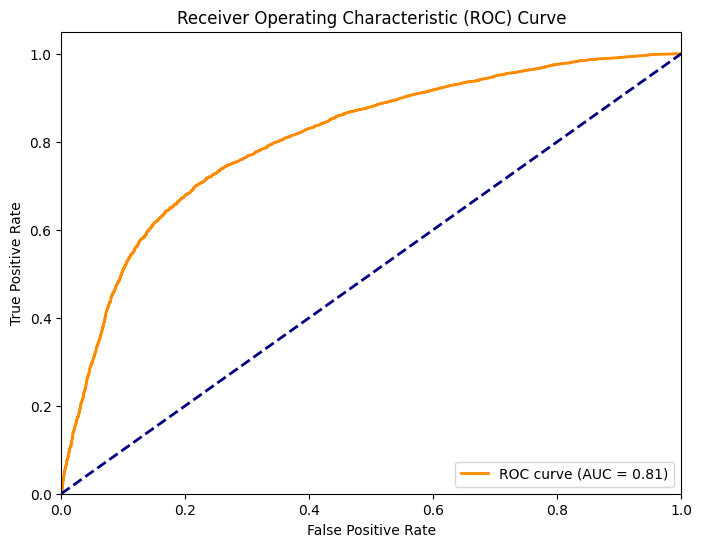

In [ ]:
# 3. ROC Curve
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 4. Brier Score (measures prediction probability calibration)
brier_score = brier_score_loss(y_test, y_pred_proba)
print(f"\nBrier Score: {brier_score:.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance.to_string(index=False))


Brier Score: 0.1842

Feature Importance:
      feature  importance
        ap_hi    0.523930
cholesterol_3    0.171999
          age    0.085516
       active    0.034331
cholesterol_2    0.032491
        ap_lo    0.029224
       gluc_3    0.026222
        smoke    0.022907
          bmi    0.022054
         alco    0.019686
       gluc_2    0.017185
       gender    0.014454


# Gradient boosting model (dont rerun, it takes a while)


In [ ]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           brier_score_loss, roc_auc_score, confusion_matrix, roc_curve)
from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded
X = df.drop(['cardio'], axis=1)
y = df['cardio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the weight ratios to test
weight_ratios = [
    (1, 1),   # Baseline
    (1, 2),   # Weight 1:2
    (2, 3),   # Weight 2:3
    (3, 4),   # Weight 3:4
    (4, 5)    # Weight 4:5
]

# Function to calculate false positive rate
def false_positive_rate(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        fp = cm[0, 1]
        tn = cm[0, 0]
        return fp / (fp + tn)
    return 0.0

# Function to print model results
def print_model_results(model_name, weights, y_test, y_pred, y_prob, cv_results=None):
    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"False Positive Rate: {false_positive_rate(y_test, y_pred):.4f}")
    print(f"Brier Score: {brier_score_loss(y_test, y_prob):.4f}")
    print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")

    if cv_results is not None:
        print("Cross-Validation (5-Fold):")
        for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']:
            mean_val = np.mean(cv_results[metric])
            std_val = np.std(cv_results[metric])
            metric_name = metric.replace('test_', '')
            print(f"{metric_name:<10}: Mean = {mean_val:.4f}, Std = {std_val:.4f}")

# Define scoring metrics for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Evaluate models with different weights
for i, (w0, w1) in enumerate(weight_ratios):
    # Create model with appropriate class weights
    if w0 == 1 and w1 == 1:
        model_name = "Baseline Gradient Boosting"
        sample_weights = None
    else:
        model_name = f"Gradient Boosting with Class Weights: {{0: {w0}, 1: {w1}}}"
        sample_weights = np.where(y_train == 0, w0, w1)

    # Define the model
    gb_model = GradientBoostingClassifier(
        learning_rate=0.1,
        n_estimators=200,
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        subsample=0.8,
        random_state=42
    )

    # For baseline model
    if i == 0:
        # First train and evaluate on test set
        gb_model.fit(X_train, y_train)
        y_pred = gb_model.predict(X_test)
        y_prob = gb_model.predict_proba(X_test)[:, 1]

        # Then do cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(gb_model, X_train, y_train, cv=cv, scoring=scoring)

        print("\n=== Baseline Gradient Boosting ===")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"Precision: {precision_score(y_test, y_pred):.4f}")
        print(f"Recall: {recall_score(y_test, y_pred):.4f}")
        print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
        print(f"False Positive Rate: {false_positive_rate(y_test, y_pred):.4f}")
        print(f"Brier Score: {brier_score_loss(y_test, y_prob):.4f}")
        print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")

        print("\n=== Cross-Validation Results (Baseline, 5-Fold) ===")
        for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']:
            mean_val = np.mean(cv_results[metric])
            std_val = np.std(cv_results[metric])
            metric_name = metric.replace('test_', '')
            print(f"{metric_name:<10}: Mean = {mean_val:.4f}, Std = {std_val:.4f}")
    else:
        # For weighted models
        # Train on full training set with weights
        gb_model.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = gb_model.predict(X_test)
        y_prob = gb_model.predict_proba(X_test)[:, 1]

        # Cross-validation with weights
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # We need to create sample weights inside the CV loop
        cv_results = []
        for train_idx, _ in cv.split(X_train, y_train):
            # Create weights for this fold
            fold_weights = np.where(y_train.iloc[train_idx] == 0, w0, w1)

            # Train model with fold-specific weights
            model = GradientBoostingClassifier(
                learning_rate=0.1,
                n_estimators=200,
                max_depth=5,
                min_samples_split=2,
                min_samples_leaf=1,
                subsample=0.8,
                random_state=42
            )
            model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx],
                     sample_weight=fold_weights)

            # Store results (simplified for demonstration)
            # In practice, you'd want to store all metrics
            cv_results.append({
                'accuracy': accuracy_score(y_train.iloc[train_idx], model.predict(X_train.iloc[train_idx])),
                'precision': precision_score(y_train.iloc[train_idx], model.predict(X_train.iloc[train_idx])),
                'recall': recall_score(y_train.iloc[train_idx], model.predict(X_train.iloc[train_idx])),
                'f1': f1_score(y_train.iloc[train_idx], model.predict(X_train.iloc[train_idx])),
                'roc_auc': roc_auc_score(y_train.iloc[train_idx], model.predict_proba(X_train.iloc[train_idx])[:, 1])
            })

        # Convert to format expected by print_model_results
        cv_metrics = {
            'test_accuracy': [res['accuracy'] for res in cv_results],
            'test_precision': [res['precision'] for res in cv_results],
            'test_recall': [res['recall'] for res in cv_results],
            'test_f1': [res['f1'] for res in cv_results],
            'test_roc_auc': [res['roc_auc'] for res in cv_results]
        }

        print_model_results(model_name, (w0, w1), y_test, y_pred, y_prob, cv_metrics)


=== Baseline Gradient Boosting ===
Accuracy: 0.7399
Precision: 0.7594
Recall: 0.6948
F1 Score: 0.7257
False Positive Rate: 0.2158
Brier Score: 0.1791
AUC: 0.8041

=== Cross-Validation Results (Baseline, 5-Fold) ===
accuracy  : Mean = 0.7324, Std = 0.0018
precision : Mean = 0.7507, Std = 0.0032
recall    : Mean = 0.6878, Std = 0.0055
f1        : Mean = 0.7179, Std = 0.0025
roc_auc   : Mean = 0.7977, Std = 0.0018

=== Gradient Boosting with Class Weights: {0: 1, 1: 2} ===
Accuracy: 0.7046
Precision: 0.6567
Recall: 0.8449
F1 Score: 0.7390
False Positive Rate: 0.4330
Brier Score: 0.1956
AUC: 0.8037
Cross-Validation (5-Fold):
accuracy  : Mean = 0.7246, Std = 0.0008
precision : Mean = 0.6725, Std = 0.0011
recall    : Mean = 0.8645, Std = 0.0013
f1        : Mean = 0.7565, Std = 0.0005
roc_auc   : Mean = 0.8329, Std = 0.0005

=== Gradient Boosting with Class Weights: {0: 2, 1: 3} ===
Accuracy: 0.7287
Precision: 0.7032
Recall: 0.7820
F1 Score: 0.7405
False Positive Rate: 0.3235
Brier Score: 0.

=== Model with Weight Ratio 2:3 ===
Cross-Validation Accuracy Scores: [0.714612, 0.718181, 0.717723, 0.727056, 0.724037]
Mean CV Accuracy: 0.7203
Standard Deviation of CV Accuracy: 0.0045

Test Set Performance:
Accuracy: 0.7287

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72      6899
           1       0.70      0.78      0.74      6763

    accuracy                           0.73     13662
   macro avg       0.73      0.73      0.73     13662
weighted avg       0.73      0.73      0.73     13662


Brier Score: 0.1851


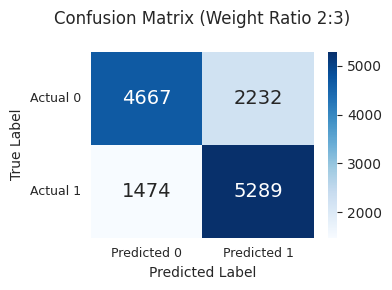

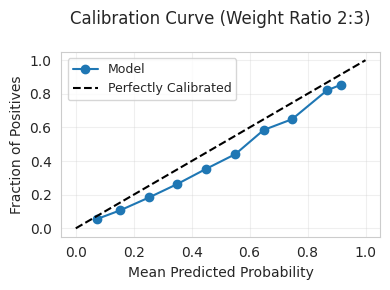

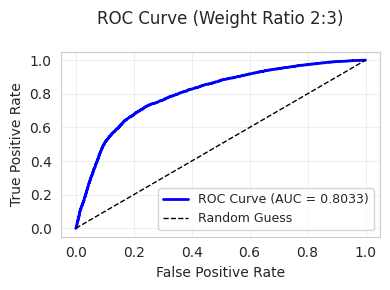

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                           brier_score_loss, confusion_matrix,
                           roc_curve, roc_auc_score,
                           precision_recall_curve, average_precision_score)
from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define weight function for Weight 2:3
def get_sample_weights(y, ratio=(2, 3)):
    return np.where(y == 0, ratio[0], ratio[1])  # (Non-Cardio: 2, Cardio: 3)

# Split the data into training and testing sets
X = df.drop(['cardio'], axis=1)
y = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Get sample weights for 2:3 ratio
sample_weights_train = get_sample_weights(y_train, ratio=(2, 3))

# Define the model with sample_weight parameter in constructor
gb_model = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=0.8,
    random_state=42
)

# New approach for cross-validation with sample weights
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_index, val_index in kf.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Get weights for this fold
    fold_weights = get_sample_weights(y_fold_train, ratio=(2, 3))

    # Clone and fit model with weights
    model = GradientBoostingClassifier(
        learning_rate=0.1,
        n_estimators=200,
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        subsample=0.8,
        random_state=42
    ).fit(X_fold_train, y_fold_train, sample_weight=fold_weights)

    # Calculate and store accuracy
    cv_scores.append(accuracy_score(y_fold_val, model.predict(X_fold_val)))

print("=== Model with Weight Ratio 2:3 ===")
print(f"Cross-Validation Accuracy Scores: {[round(score, 6) for score in cv_scores]}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of CV Accuracy: {np.std(cv_scores):.4f}")

# Train the model on the full training set with sample weights
gb_model.fit(X_train, y_train, sample_weight=sample_weights_train)

# Make predictions on the test set
y_pred = gb_model.predict(X_test)
y_prob = gb_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Evaluate the model
print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nBrier Score: {brier_score_loss(y_test, y_prob):.4f}")

# Set overall style for all plots
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# 1. Confusion Matrix
plt.figure(figsize=(4, 3))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            annot_kws={"size": 14},
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Weight Ratio 2:3)', fontsize=12, pad=20)
plt.ylabel('True Label', fontsize=10)
plt.xlabel('Predicted Label', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9, rotation=0)
plt.tight_layout()
plt.show()

# 2. Calibration Curve
plt.figure(figsize=(4, 3))
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')
plt.plot(prob_pred, prob_true, marker='o', markersize=6, label="Model")
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability", fontsize=10)
plt.ylabel("Fraction of Positives", fontsize=10)
plt.title("Calibration Curve (Weight Ratio 2:3)", fontsize=12, pad=20)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. ROC Curve
plt.figure(figsize=(4, 3))
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=1, label="Random Guess")
plt.xlabel("False Positive Rate", fontsize=10)
plt.ylabel("True Positive Rate", fontsize=10)
plt.title("ROC Curve (Weight Ratio 2:3)", fontsize=12, pad=20)
plt.legend(fontsize=9, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Get feature importances
feature_importances = gb_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print feature importance table
print("\n=== Feature Importance Table ===")
print(importance_df.to_string(index=False))


=== Feature Importance Table ===
      Feature  Importance
        ap_hi    0.606816
          age    0.159137
          bmi    0.097550
cholesterol_3    0.060881
        ap_lo    0.023624
       active    0.011612
cholesterol_2    0.010800
       gluc_3    0.008013
       gender    0.006028
        smoke    0.005766
       gluc_2    0.005128
         alco    0.004645


# Decision Tree Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [ ]:
X = df.drop(columns=['cardio'])  # Features
y = df['cardio']  # Target variable

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

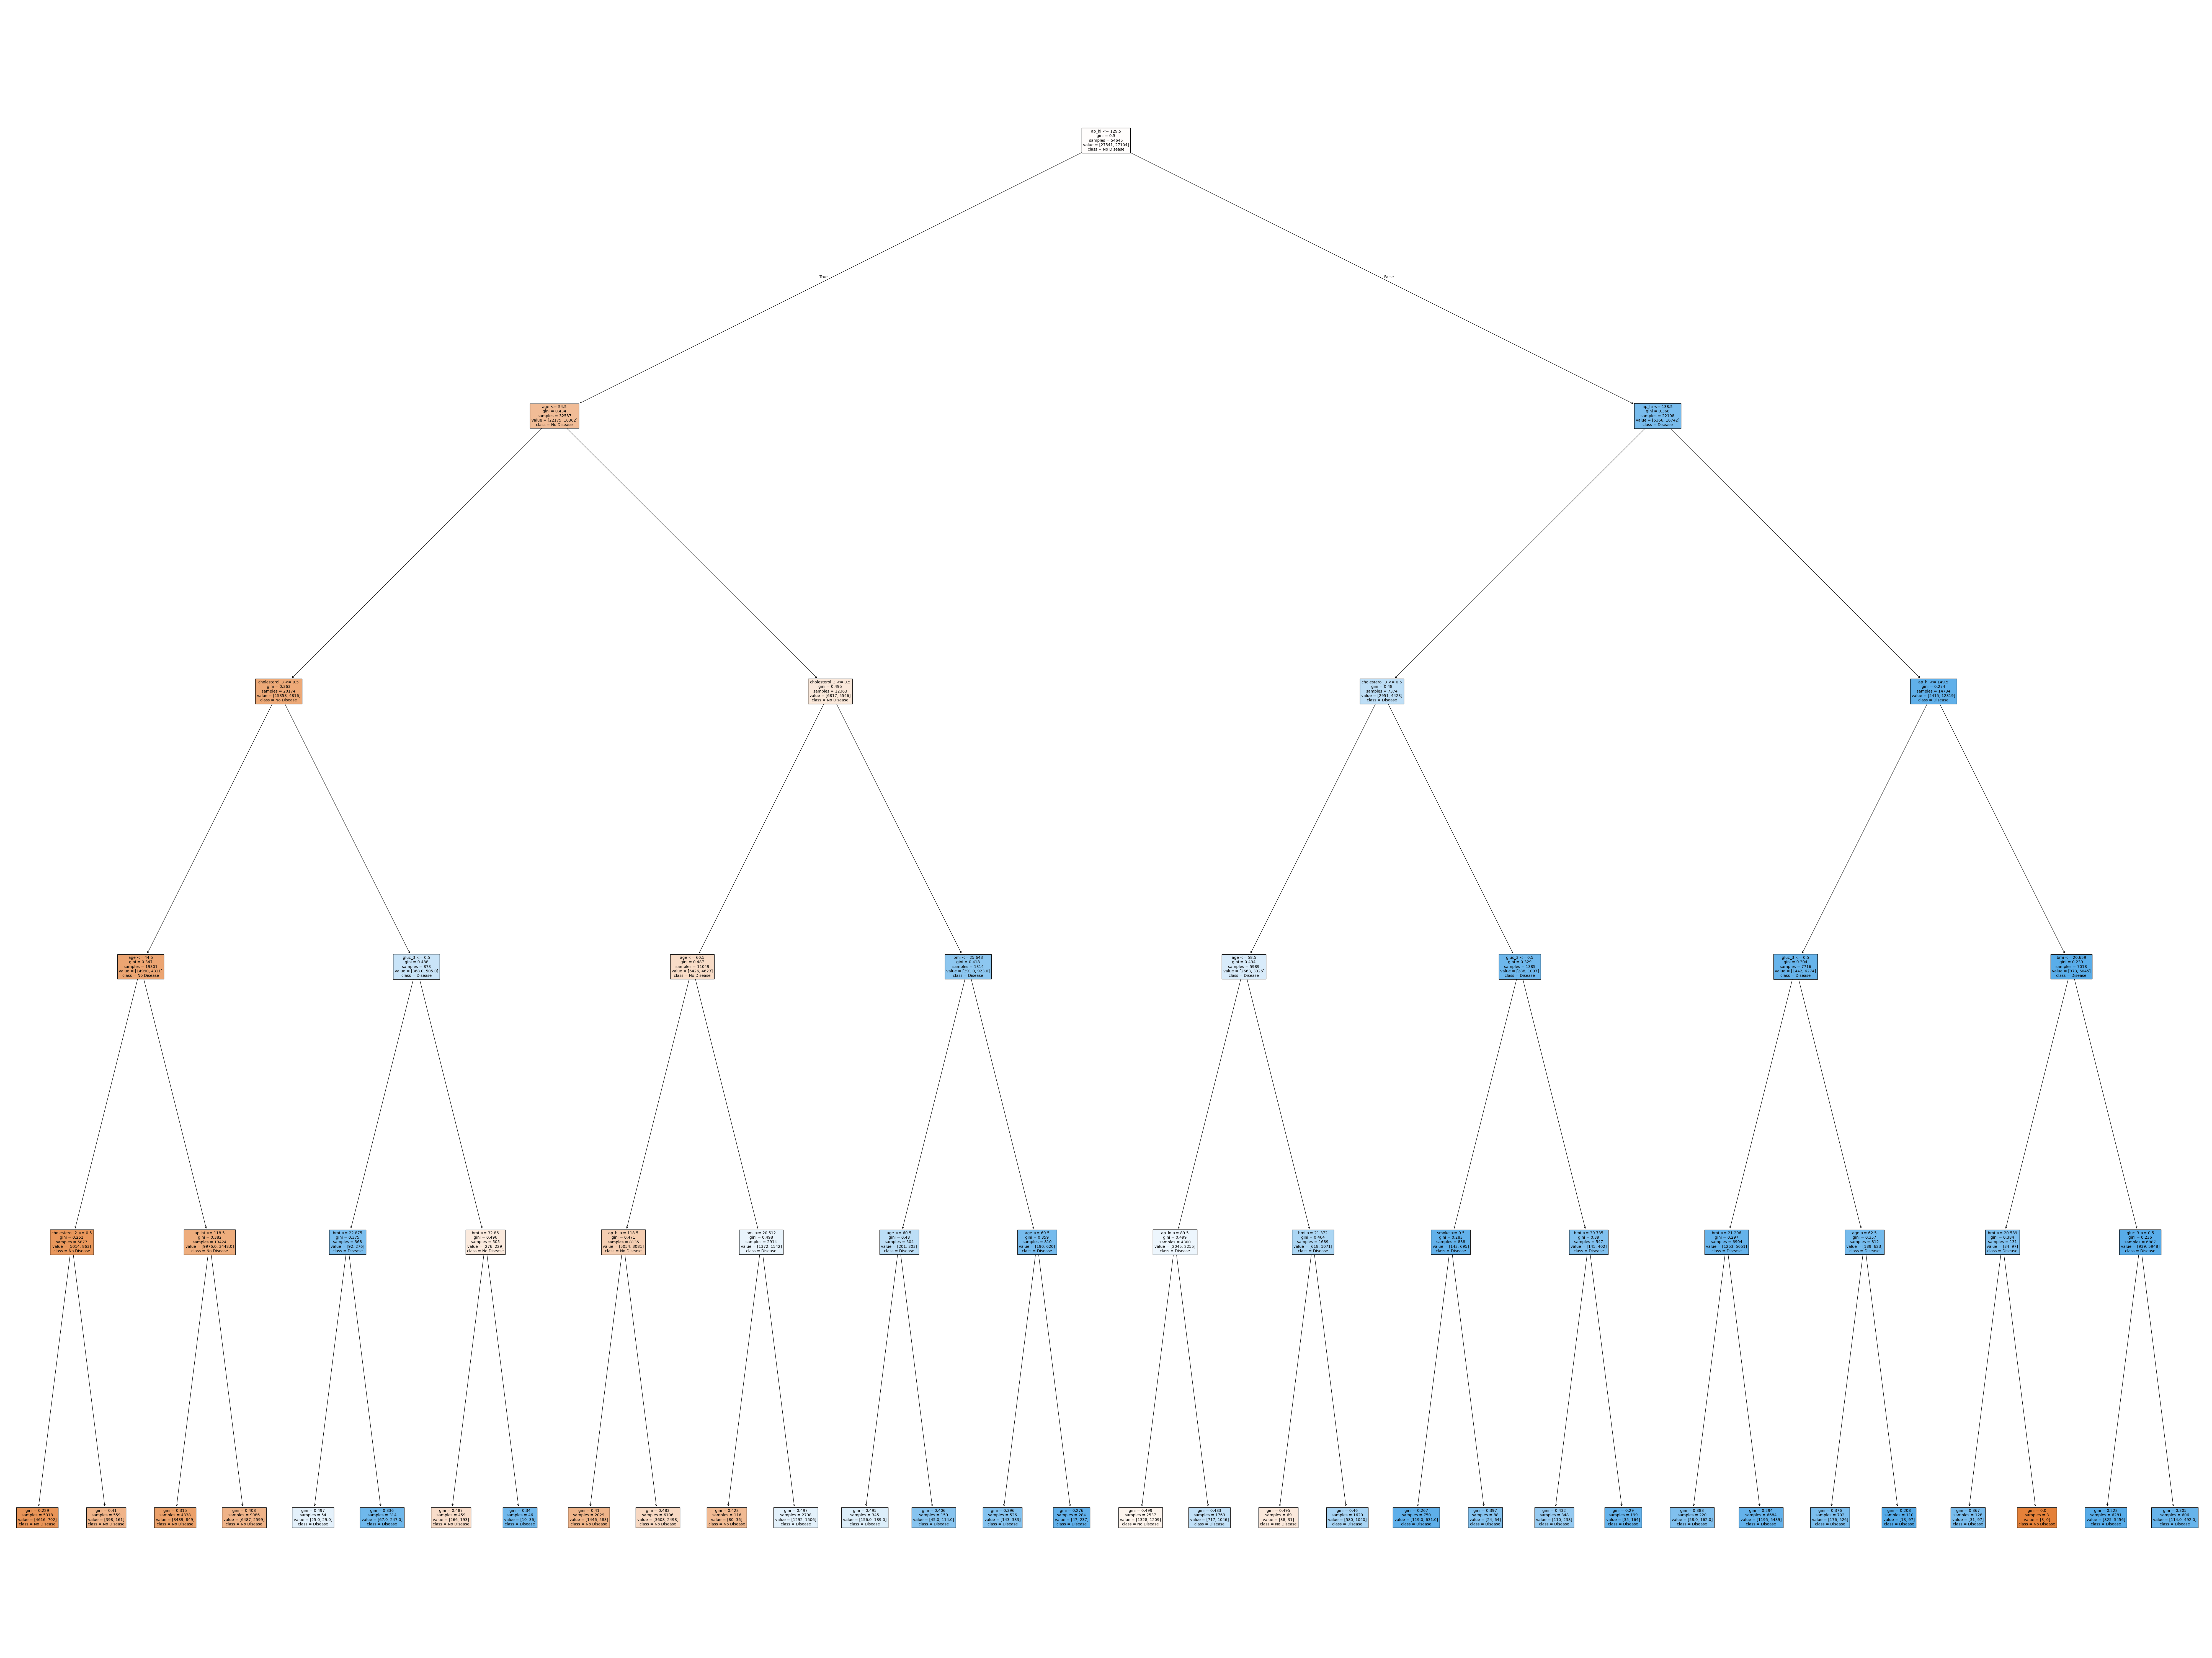

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(80, 60))  # Increase figure size to fit the full tree
plot_tree(model,
          feature_names=X.columns,
          class_names=['No Disease', 'Disease'],
          filled=True,
          fontsize=10)         # Smaller font to fit more text
plt.tight_layout()
plt.show()

In [ ]:


from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}


Cross-Validation Accuracy Scores: [0.73391893 0.73236344 0.72540946 0.73035044 0.72751395]
Mean CV Accuracy: 0.7299
Standard Deviation of CV Accuracy: 0.0031

Model Performance on Test Set:
Accuracy: 0.7325

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      6954
           1       0.76      0.67      0.71      6708

    accuracy                           0.73     13662
   macro avg       0.74      0.73      0.73     13662
weighted avg       0.74      0.73      0.73     13662


Confusion Matrix:
[[5518 1436]
 [2219 4489]]


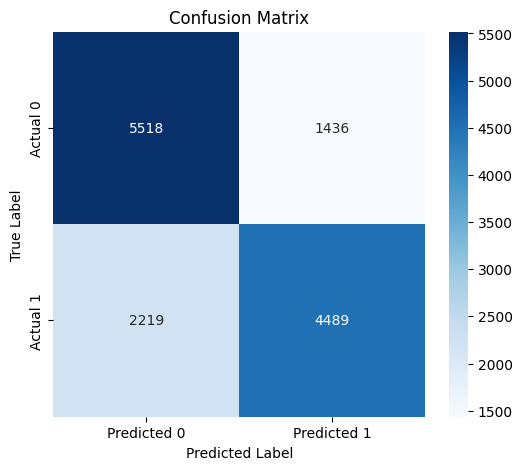


Brier Score: 0.1831 (Lower is better)


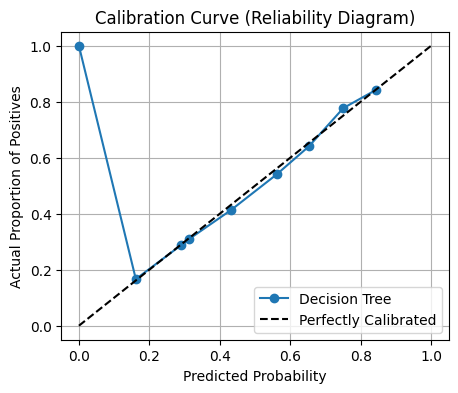

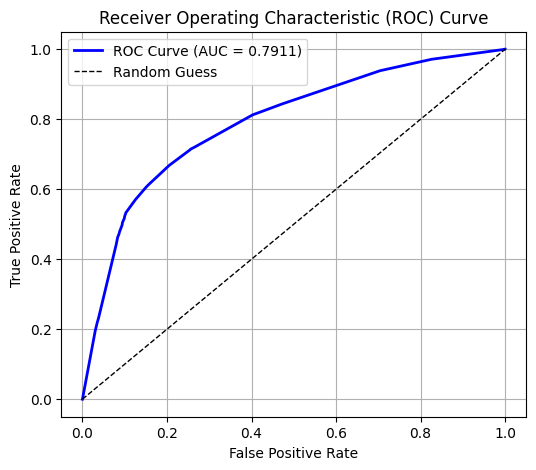

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, brier_score_loss, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded
X = df.drop(['cardio'], axis=1)
y = df['cardio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Decision Tree model with class weights set to 'balanced'
model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    random_state=42,
    class_weight='balanced'  # Set class weights to 'balanced'
)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of CV Accuracy: {np.std(cv_scores):.4f}")

# Train the model on the full training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Evaluate the model
print("\nModel Performance on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Brier Score (Measures calibration)
brier_score = brier_score_loss(y_test, y_prob)
print(f"\nBrier Score: {brier_score:.4f} (Lower is better)")

# Calibration Curve (Reliability Diagram)
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')

plt.figure(figsize=(5, 4))
plt.plot(prob_pred, prob_true, marker='o', label="Decision Tree")
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label="Perfectly Calibrated")
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Proportion of Positives")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend()
plt.grid()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=1, label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Additional metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.7576
Recall: 0.6692
F1 Score: 0.7107


Class weight adjustment for minimizing false negatives and improving recall


Evaluating with Base (1:1)...
Cross-Validation Accuracy Scores: [0.73391893 0.73236344 0.72540946 0.73035044 0.72751395]
Mean CV Accuracy: 0.7299
Standard Deviation of CV Accuracy: 0.0031

Model Performance on Test Set:
Accuracy: 0.7325

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      6954
           1       0.76      0.67      0.71      6708

    accuracy                           0.73     13662
   macro avg       0.74      0.73      0.73     13662
weighted avg       0.74      0.73      0.73     13662


Confusion Matrix:
[[5518 1436]
 [2219 4489]]


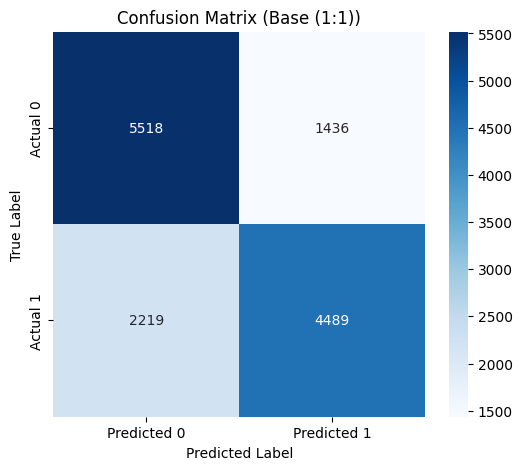


Brier Score: 0.1831 (Lower is better)


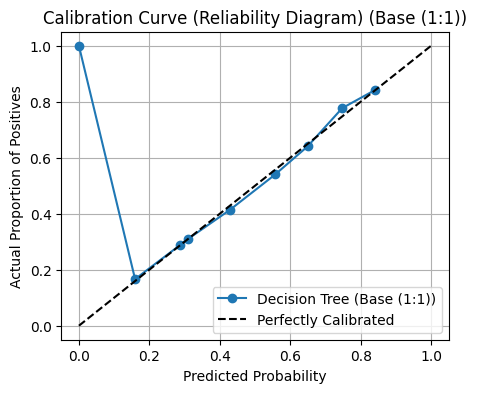

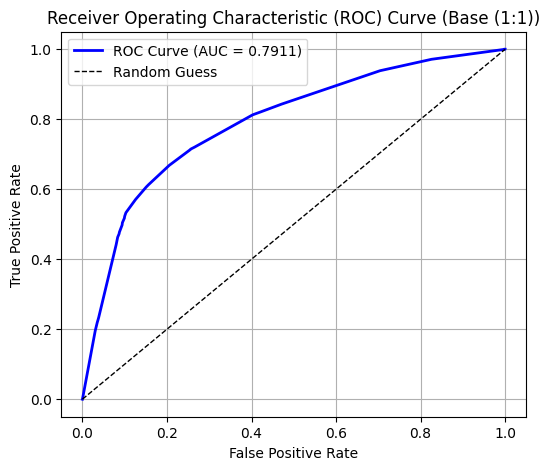


Evaluating with Weight 1:2...
Cross-Validation Accuracy Scores: [0.71031201 0.71076951 0.70701803 0.69210358 0.70015555]
Mean CV Accuracy: 0.7041
Standard Deviation of CV Accuracy: 0.0071

Model Performance on Test Set:
Accuracy: 0.7038

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.60      0.67      6954
           1       0.66      0.81      0.73      6708

    accuracy                           0.70     13662
   macro avg       0.71      0.71      0.70     13662
weighted avg       0.72      0.70      0.70     13662


Confusion Matrix:
[[4172 2782]
 [1265 5443]]


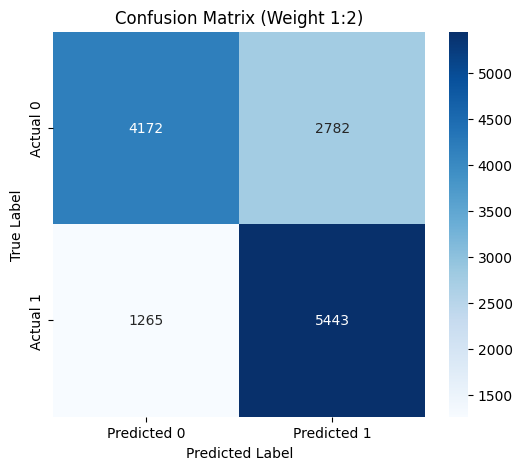


Brier Score: 0.2015 (Lower is better)


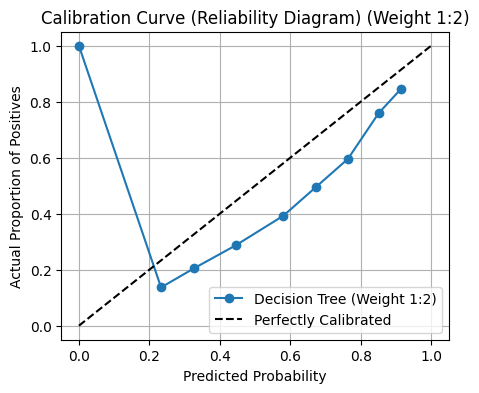

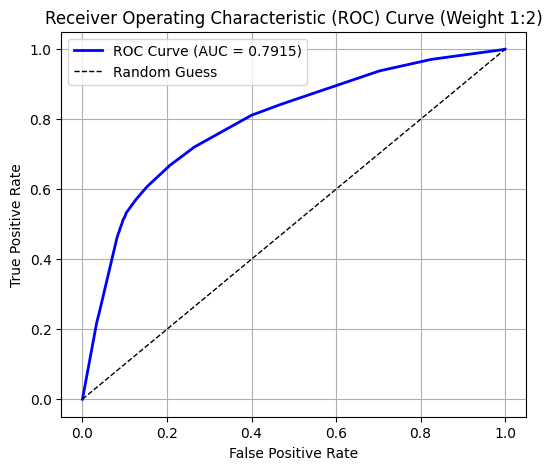


Evaluating with Weight 2:3...
Cross-Validation Accuracy Scores: [0.71022051 0.71012901 0.70710953 0.71086101 0.70015555]
Mean CV Accuracy: 0.7077
Standard Deviation of CV Accuracy: 0.0040

Model Performance on Test Set:
Accuracy: 0.7029

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.60      0.67      6954
           1       0.66      0.81      0.73      6708

    accuracy                           0.70     13662
   macro avg       0.71      0.70      0.70     13662
weighted avg       0.71      0.70      0.70     13662


Confusion Matrix:
[[4154 2800]
 [1259 5449]]


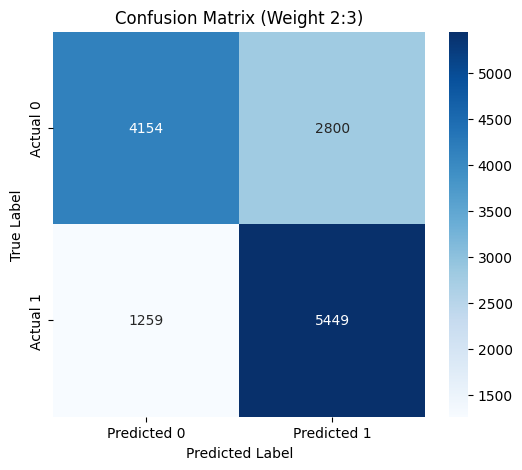


Brier Score: 0.1896 (Lower is better)


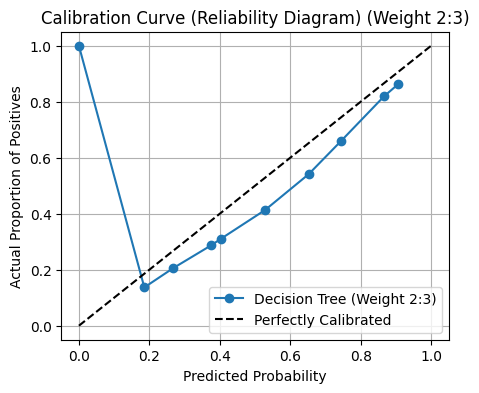

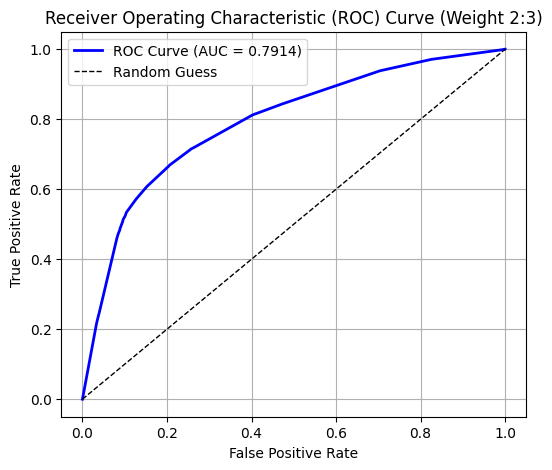


Evaluating with Weight 3:4...
Cross-Validation Accuracy Scores: [0.73163144 0.72952695 0.72495196 0.73099094 0.72467746]
Mean CV Accuracy: 0.7284
Standard Deviation of CV Accuracy: 0.0030

Model Performance on Test Set:
Accuracy: 0.7295

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74      6954
           1       0.73      0.71      0.72      6708

    accuracy                           0.73     13662
   macro avg       0.73      0.73      0.73     13662
weighted avg       0.73      0.73      0.73     13662


Confusion Matrix:
[[5175 1779]
 [1917 4791]]


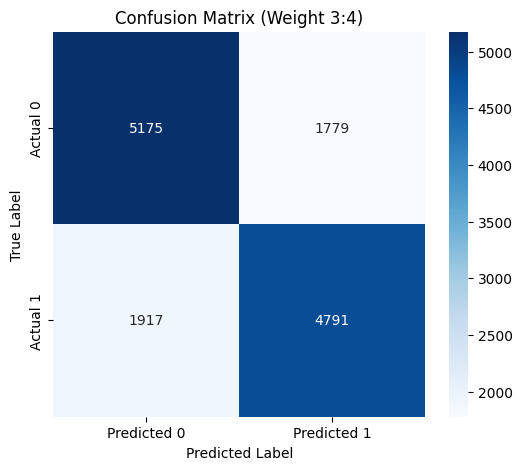


Brier Score: 0.1864 (Lower is better)


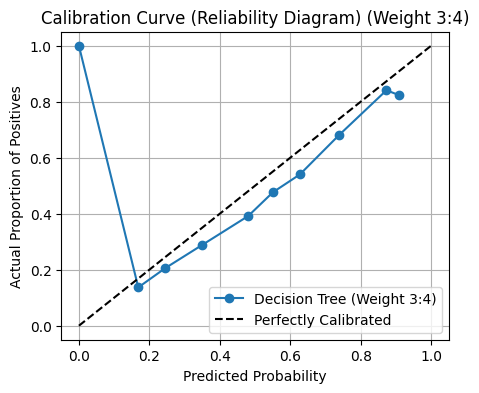

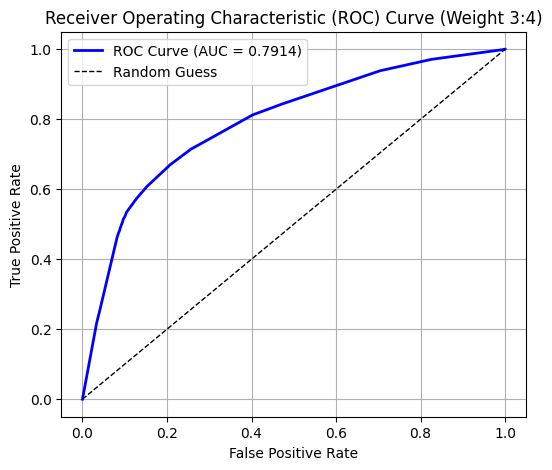


Evaluating with Weight 4:5...
Cross-Validation Accuracy Scores: [0.73163144 0.72842895 0.72495196 0.73099094 0.72467746]
Mean CV Accuracy: 0.7281
Standard Deviation of CV Accuracy: 0.0029

Model Performance on Test Set:
Accuracy: 0.7295

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74      6954
           1       0.73      0.71      0.72      6708

    accuracy                           0.73     13662
   macro avg       0.73      0.73      0.73     13662
weighted avg       0.73      0.73      0.73     13662


Confusion Matrix:
[[5175 1779]
 [1917 4791]]


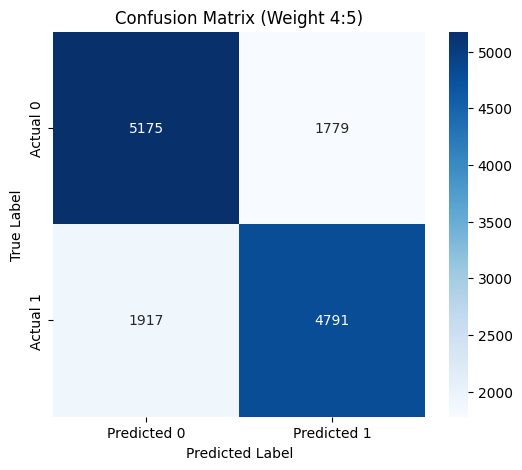


Brier Score: 0.1852 (Lower is better)


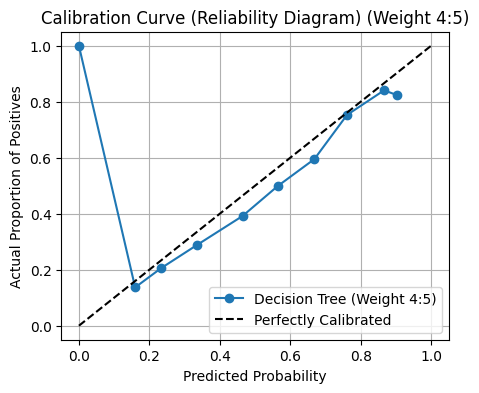

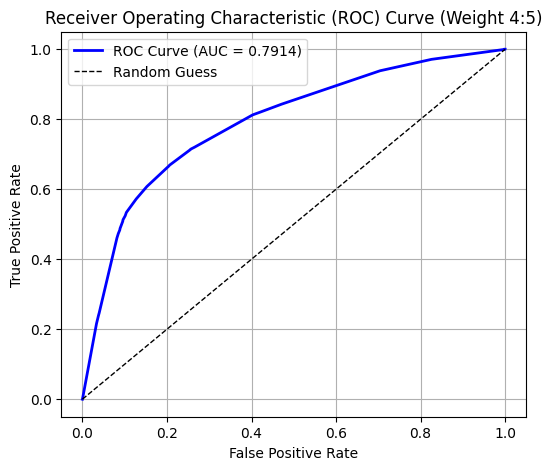

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, brier_score_loss, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded
X = df.drop(['cardio'], axis=1)
y = df['cardio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the weight ratios and labels for each configuration
weight_ratios = [(1, 1), (1, 2), (2, 3), (3, 4), (4, 5)]
weight_labels = ["Base (1:1)", "Weight 1:2", "Weight 2:3", "Weight 3:4", "Weight 4:5"]

# Loop through each weight configuration
for (w0, w1), label in zip(weight_ratios, weight_labels):
    print(f"\nEvaluating with {label}...")

    # Define the model with the current class weights
    model = DecisionTreeClassifier(
        criterion='gini',
        max_depth=5,
        random_state=42,
        class_weight={0: w0, 1: w1}  # Set the current weight configuration
    )

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    print(f"Cross-Validation Accuracy Scores: {cv_scores}")
    print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")
    print(f"Standard Deviation of CV Accuracy: {np.std(cv_scores):.4f}")

    # Train the model on the full training set
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

    # Evaluate the model
    print("\nModel Performance on Test Set:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix ({label})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Brier Score (measures how well-calibrated the model's predicted probabilities are)
    brier_score = brier_score_loss(y_test, y_prob)
    print(f"\nBrier Score: {brier_score:.4f} (Lower is better)")

    # Calibration Curve (Reliability Diagram)
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')

    plt.figure(figsize=(5, 4))
    plt.plot(prob_pred, prob_true, marker='o', label=f"Decision Tree ({label})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label="Perfectly Calibrated")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Actual Proportion of Positives")
    plt.title(f"Calibration Curve (Reliability Diagram) ({label})")
    plt.legend()
    plt.grid()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=1, label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver Operating Characteristic (ROC) Curve ({label})")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
print(f"Recall for class 1: {recall_score(y_test, y_pred)}")
print(f"F1-Score for class 1: {f1_score(y_test, y_pred)}")

Recall for class 1: 0.714221824686941
F1-Score for class 1: 0.7216448260280163


Cross-Validation Accuracy Scores: [0.72467746 0.72632446 0.73089944 0.72833745 0.72751395]
Mean CV Accuracy: 0.7276
Standard Deviation of CV Accuracy: 0.0021
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.74      0.74      6899
           1       0.73      0.72      0.73      6763

    accuracy                           0.73     13662
   macro avg       0.73      0.73      0.73     13662
weighted avg       0.73      0.73      0.73     13662

Brier Score: 0.1856


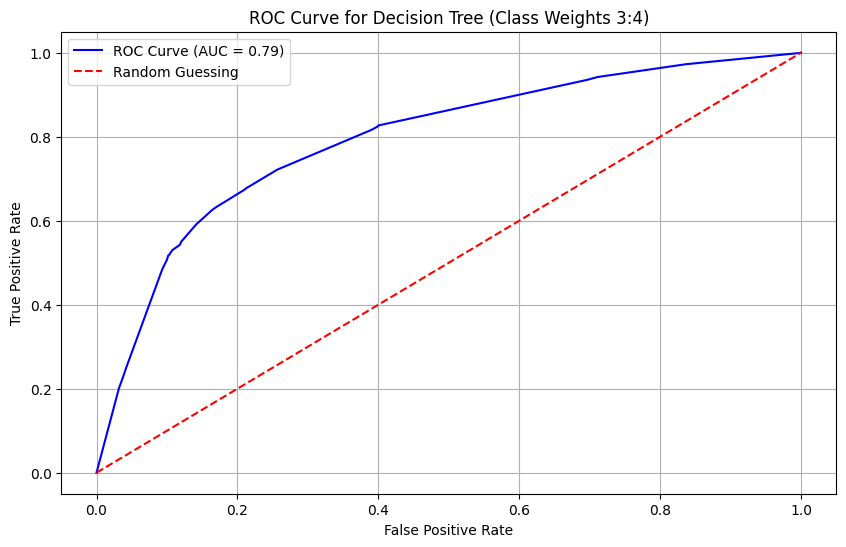

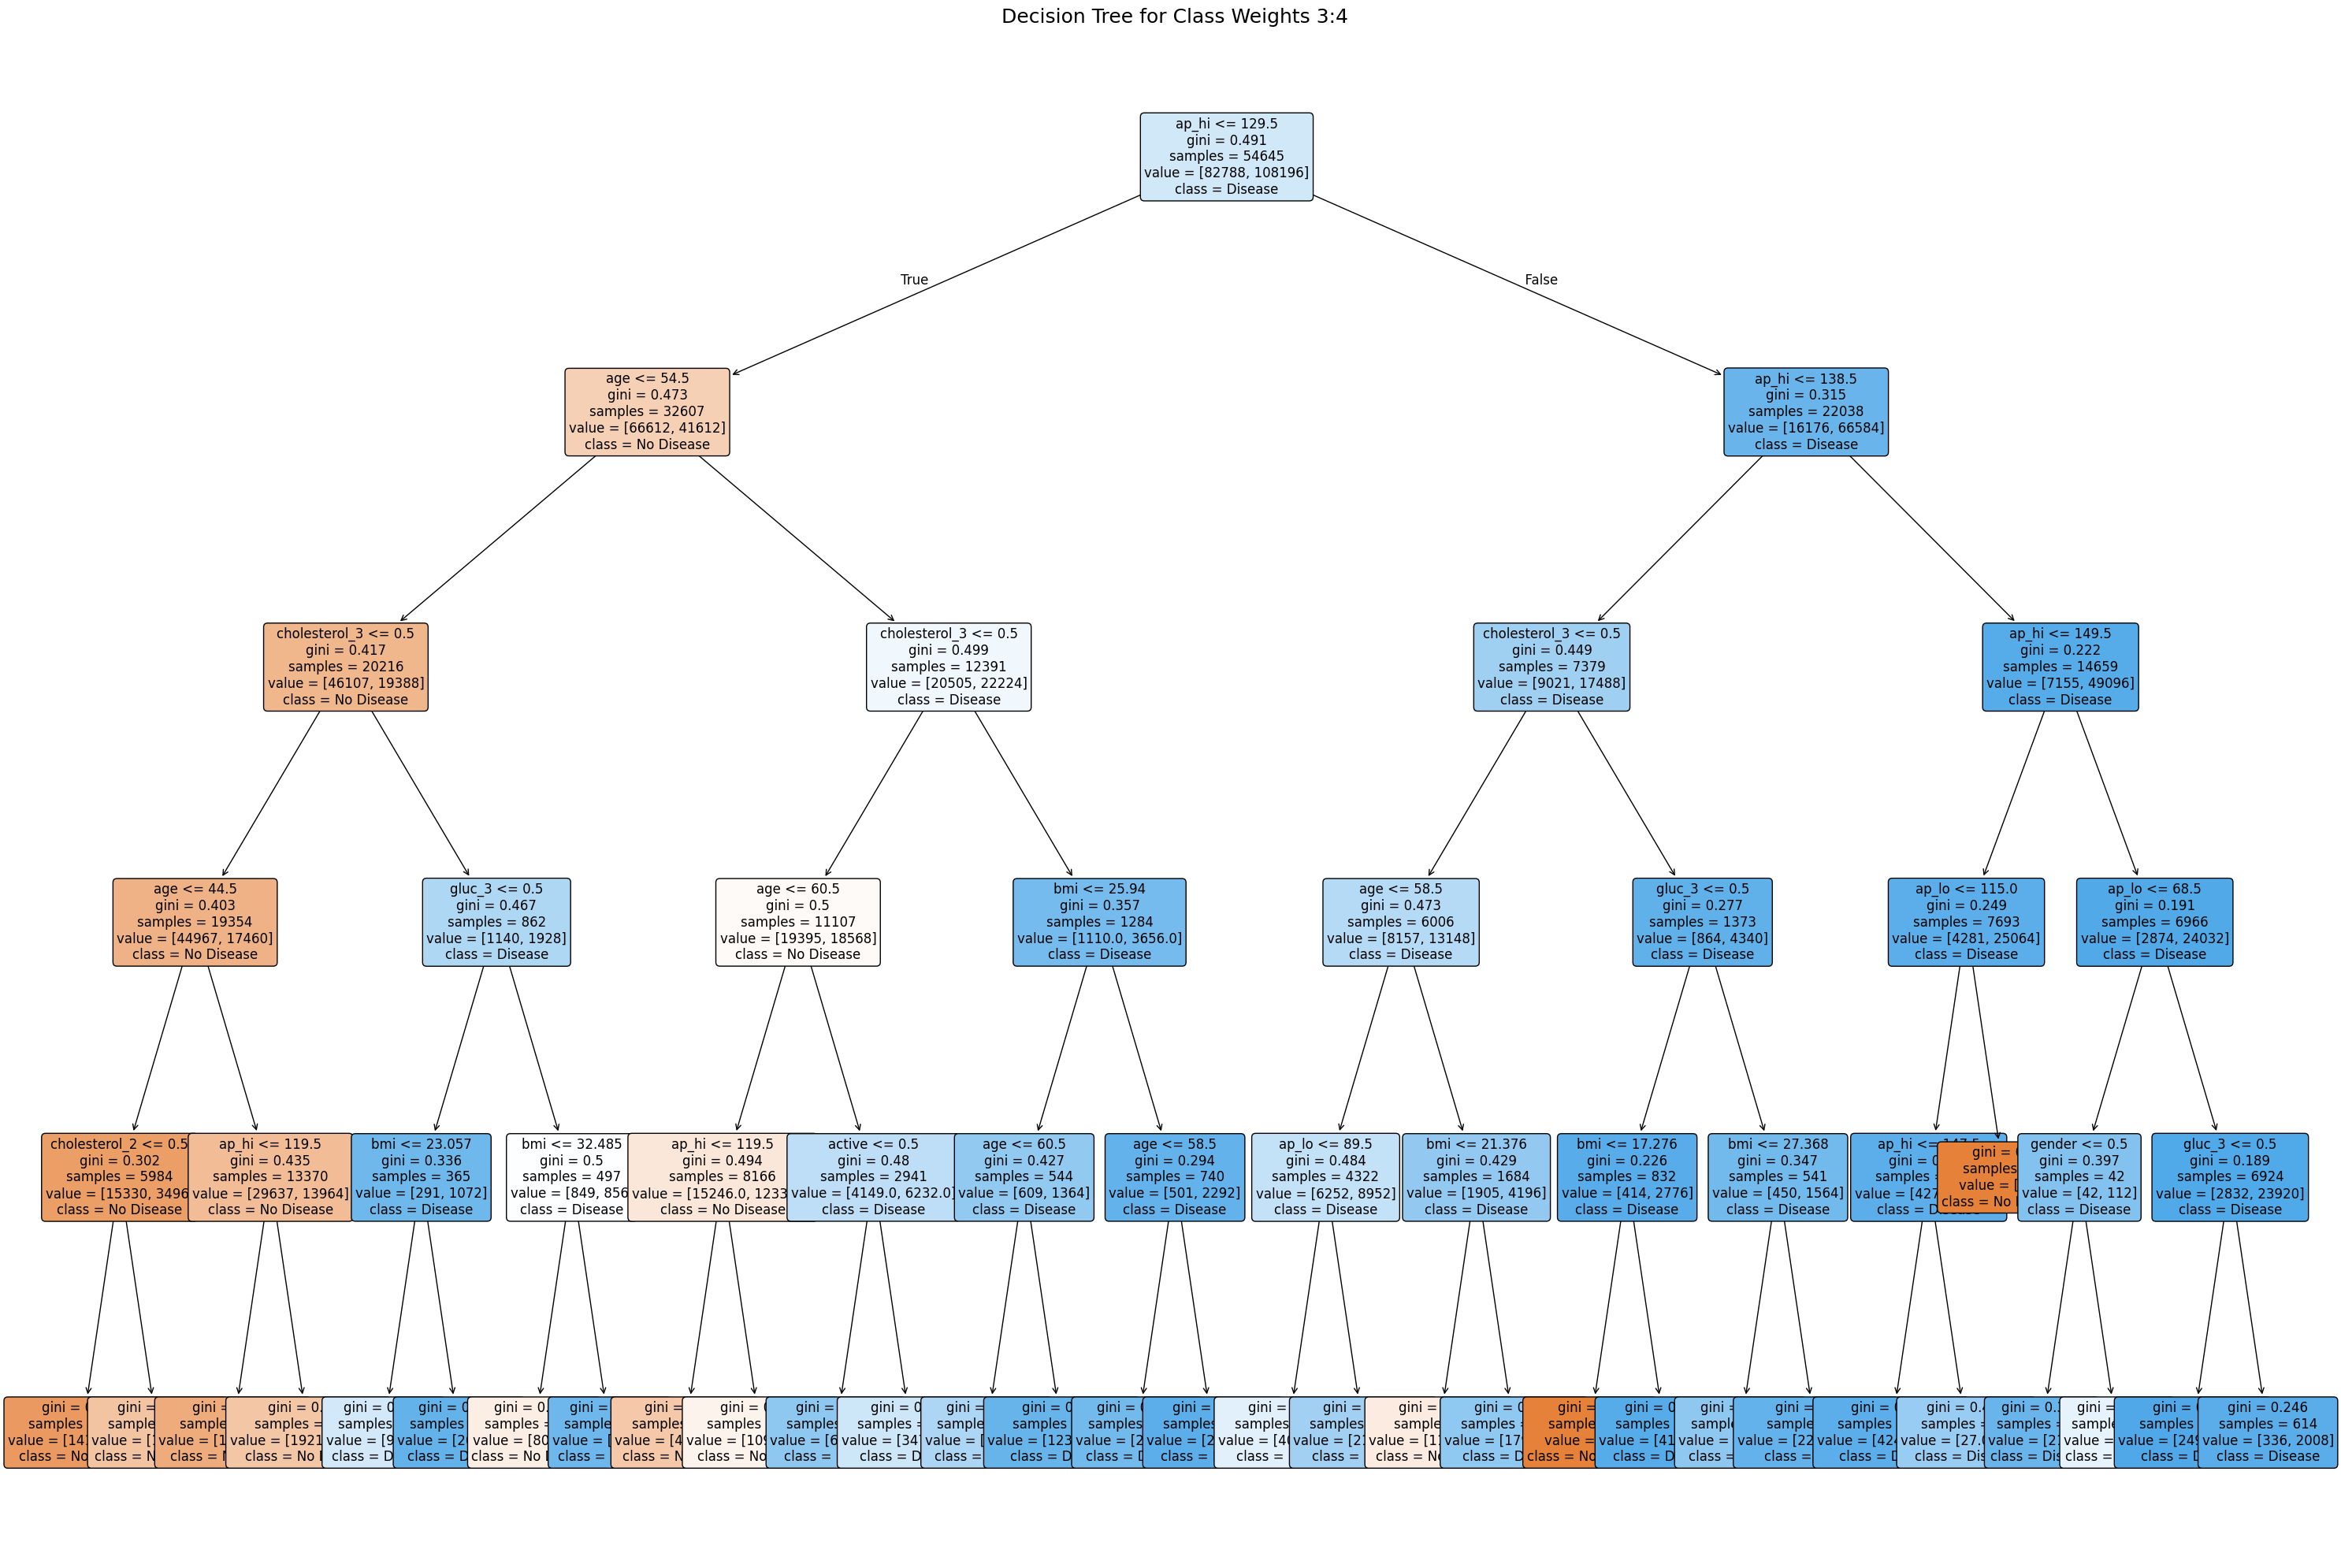

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss, classification_report
import matplotlib.pyplot as plt

# Assuming 'df' is your preprocessed dataset
# Example:
# df = pd.read_csv('your_dataset.csv')

# Separate features (X) and target variable (y)
X = df.drop(columns=['cardio'])  # Features
y = df['cardio']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the decision tree classifier with weights 3:4
model = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42, class_weight={0: 3, 1: 4})

# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of CV Accuracy: {np.std(cv_scores):.4f}")

# Train the model on the training data
model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate and print Brier score
brier_score = brier_score_loss(y_test, y_prob)
print(f"Brier Score: {brier_score:.4f}")

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Decision Tree (Class Weights 3:4)")
plt.legend()
plt.grid()
plt.show()

# Plot the decision tree
plt.figure(figsize=(30, 20))  # Adjust the figure size for better readability
plot_tree(
    model,
    feature_names=X.columns,
    class_names=['No Disease', 'Disease'],
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title('Decision Tree for Class Weights 3:4', fontsize=18)
plt.tight_layout()
plt.show()